In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.colors as mpl_colors
from matplotlib import cm as cmx
from matplotlib.ticker import FormatStrFormatter
from HIImodels import modObj,altBPT,pxl_plot,nColors,getColors
from UVplotting import(redden, deredden, wind_arrow, plot_sench_ratio,
                       plot_reddening_vector, plot_reddening_single,
                       make_inset, make_logZ_plot, ratio_ratio, redden_ratio)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('font',size=16,family='serif',
       serif=[r'cmr10'],style='normal',
       variant='normal',stretch='normal')#,weight='heavy')
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
import sys
sys.path.append('/astro/users/ebyler/python/mangst/mangst/')
import lineinds

In [3]:
import UVplotting
reload(UVplotting)
import HIImodels
reload(HIImodels)

<module 'HIImodels' from 'HIImodels.pyc'>

In [4]:
def getModelSpec(logZ=-0.5, logU=-1.0, age=None, emis=True,
                 sfh='burst', track='mist', subdir='AbsEmData', #subdir='spec',
                 dir_='/astro/users/ebyler/research/uvem/data'):
    '''
    subdir: 'IIZwData' or 'AbsEmData'
    sfh: 'csfr' or 'burst'
    track: 'mist' or 'pdva'
    '''
    fulldir='{}/{}'.format(dir_, subdir)
    if logZ < 0.0:
        logZstr = 'm{0:02.0f}'.format(np.abs(logZ)*10)
    else:
        logZstr = 'p{0:02.0f}'.format(np.abs(logZ)*10)
    estr = ''
    if emis:
        estr='e_'
    logUstr = 'logU_{0:.1f}_'.format(logU*-1)
    flname = '{}/{}{}_{}_{}.dat'.format(fulldir,
                                        logUstr,
                                        track,
                                        sfh,
                                        logZstr)
    data = np.genfromtxt(flname, delimiter=',')
    lam = data[:,0]
    specs = [data[:,i+1] for i in range(data.shape[1]-1)]
    with open(flname, 'r') as f:
        first_line = f.readline()
    agestrs = first_line[1::].strip('\n').split(',')[1::]
    ages = np.array([float(agestr) for agestr in agestrs])
    agesMyr = (10.**ages)/1.e6
    if age is None:
        return lam, specs
    else:
        age_ind = np.argmin(np.abs(agesMyr - age))
        return lam, specs[age_ind]
# --------------------------------------------------------------
def panel_plot(lims, ax=None,lw=1.5,
               logU=-2.5, age=2.0, sfh='csfr',
               plt_leg=False, plt_lab=False):
    if ax is None:
        fig, ax = plt.subplots(1)
    #
    logZs = [-1.5, -1.0, -0.5, 0.0]
    Zstrs = ['m{0:02.0f}'.format(np.abs(logZ)*10) if logZ < 0.0 else 'p{0:02.0f}'.format(np.abs(logZ)*10) for logZ in logZs]
    
    sMz = getColors(np.linspace(-2., 0.5), cname='inferno', minv=0.1, maxv=0.9)
    Zcolors = [sMz.to_rgba(z) for z in logZs]
    ####
    pymin, pymax = 0,0
    for logZ, Zstr, col in zip(logZs, Zstrs, Zcolors):
        lam, spec = getModelSpec(logZ=logZ, logU=logU,
                                 age=age, sfh=sfh)
        lab = '$-{0:.1f}$'.format(float(Zstr[1::])/10.) if Zstr[0] == 'm' else '$+{0:.1f}$'.format(float(Zstr[1::])/10.)
        inds = (lam >= lims[0]) & (lam <= lims[1])
        ax.plot(lam[inds], spec[inds], color=col, lw=lw, label=lab)
        ####
        ymin = 0.9*np.min(spec[inds])
        ymax = 1.4*(np.median(spec[inds]))
        if ymax > pymax:
            pymax = ymax
        if (ymin < pymin) or (pymin == 0):
            pymin = ymin
    ax.set_xlim(lims[0], lims[1])
    ax.set_ylim(pymin, pymax)
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.set_yticks([])
    ax.set_ylabel(r'F$_{\lambda}$ (L$_{\odot}/\mathrm{\AA}$)', size=14)
    plt.setp(ax.get_xticklabels(), fontsize=10)
    if plt_lab:
        ax.annotate('log $\mathcal{{U}}_{{0}}$ = {0:.1f}'.format(logU),
                    xy=(0.05, 0.05),ha='left',va='bottom',
                    xycoords='axes fraction', size=12)
    if plt_leg:
        leg = ax.legend(title=r'log Z/Z$_{\odot}$', fontsize=10,
                        frameon=True, handletextpad=0.05, labelspacing=0.1)
        plt.setp(leg.get_title(), fontsize=12)
    return
def zpanel_plot(lims, ax=None, lw=1.5,
                logU=-2.5, logZ=-0.5, sfh='csfr',
                plt_leg=False, plt_lab=False):
    if ax is None:
        fig, ax = plt.subplots(1)
    #
    ages = [1., 2., 3., 5., 7.0]
    astrs = ['{0:.0f}'.format(a) for a in ages]
    acolors = nColors(len(ages), minv=0.2, maxv=0.65, cname='CMRmap')
    ####
    pymin, pymax = 0,0
    for age, astr, col in zip(ages, astrs, acolors):
        lam, spec = getModelSpec(logZ=logZ, logU=logU,
                                 age=age, sfh=sfh)
        inds = (lam >= lims[0]) & (lam <= lims[1])
        ax.plot(lam[inds], spec[inds], color=col, lw=lw, label=astr)
        ####
        ymin = 0.9*np.min(spec[inds])
        ymax = 1.4*(np.median(spec[inds]))#+0.5*np.min(spec[inds]))
        if ymax > pymax:
            pymax = ymax
        if (ymin < pymin) or (pymin == 0):
            pymin = ymin
    ax.set_xlim(lims[0], lims[1])
    ax.set_ylim(pymin, pymax)
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.set_yticks([])
    ax.set_ylabel(r'F$_{\lambda}$ (L$_{\odot}/\mathrm{\AA}$)', size=14)
    plt.setp(ax.get_xticklabels(), fontsize=10)
    if plt_lab:
        ax.annotate('log $\mathcal{{U}}_{{0}}$ = {0:.1f}'.format(logU),
                    xy=(0.05, 0.05),ha='left',va='bottom',
                    xycoords='axes fraction', size=12)
    if plt_leg:
        leg = ax.legend(title=r'Age (Myr)', fontsize=10,
                        frameon=True, handletextpad=0.05, labelspacing=0.1)
        plt.setp(leg.get_title(), fontsize=12)
    return

# Figure 1: UV spectra for 4 Myr CSFR at logZ = -2, -1.5, -1, -0.5, 0.0

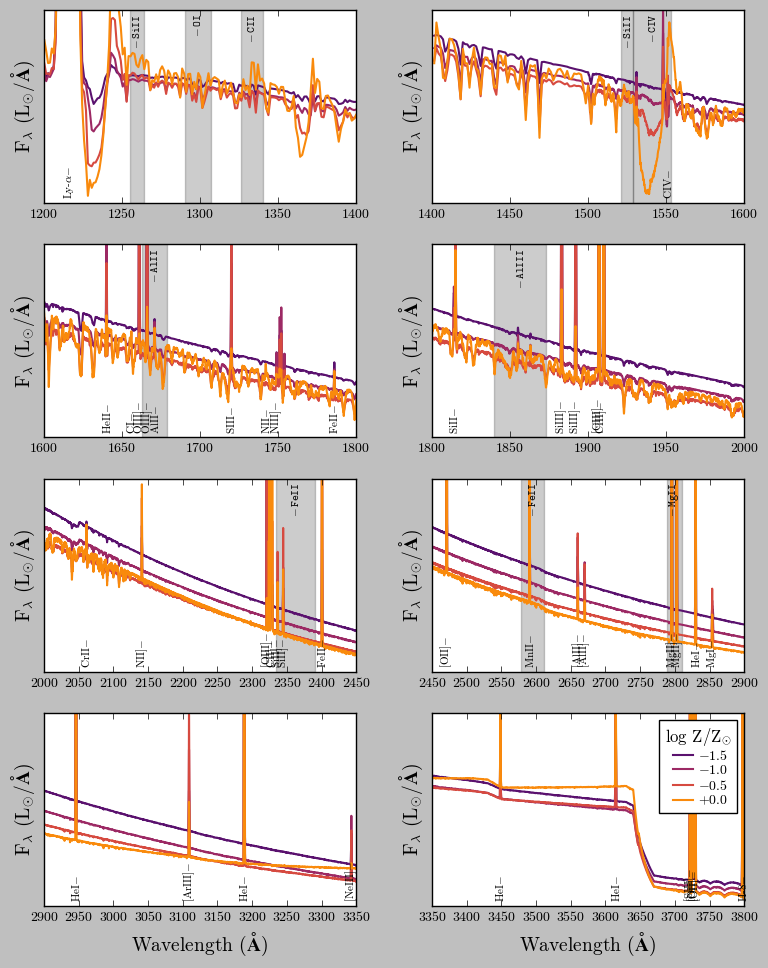

In [5]:
xlims = [(1200, 1400),
         (1400, 1600),
         (1600, 1800),
         (1800,2000),
         (2000,2450),
         (2450,2900),
         (2900,3350),
         (3350,3800)]
nrows = len(xlims)
fig, axes = plt.subplots(nrows/2,2, figsize=(8,10.))
for i, xlim in enumerate(xlims):
    ax = fig.axes[i]
    plt_leg = False if i < (nrows-1) else True
    plt_lab = False #if i > 0 else True
    panel_plot(xlim, ax=ax, plt_leg=plt_leg, plt_lab=plt_lab, lw=1.5)
    lineinds.plotLines(ax, emission_only=False, uv_sparse=True,#uv_lines=True,
                       fontsize=8)
fig.axes[-2].set_xlabel('Wavelength ($\mathrm{\AA}$)', size=14)
ax.set_xlabel('Wavelength ($\mathrm{\AA}$)', size=14)
plt.tight_layout()
fig.savefig('../figs/f1.pdf')
fig.savefig('../figs/f1.png')

# Figure 2: UV spectra for logZ = -1 at 1,2,3,5,7 Myr

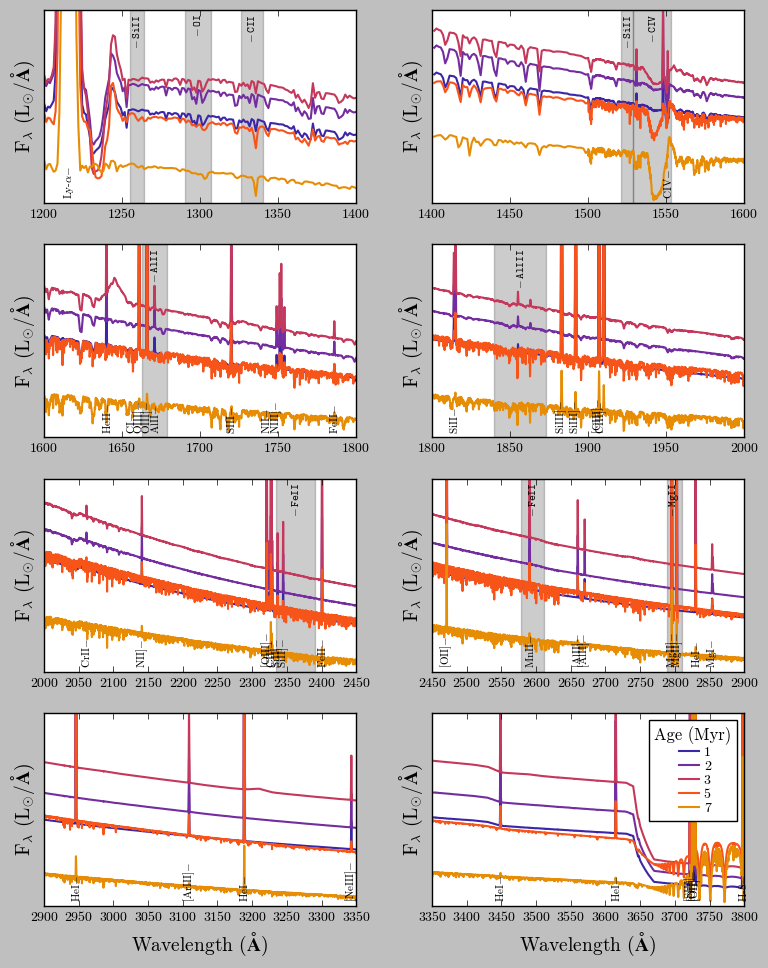

In [6]:
xlims = [(1200, 1400),
         (1400, 1600),
         (1600, 1800),
         (1800,2000),
         (2000,2450),
         (2450,2900),
         (2900,3350),
         (3350,3800)]
nrows = len(xlims)
fig, axes = plt.subplots(nrows/2,2, figsize=(8,10.))
for i, xlim in enumerate(xlims):
    ax = fig.axes[i]
    plt_leg = False if i < (nrows-1) else True
    plt_lab = False #if i > 0 else True
    zpanel_plot(xlim, ax=ax, plt_leg=plt_leg, sfh='burst',
                plt_lab=plt_lab, logZ=-1.0)
    lineinds.plotLines(ax, emission_only=False,
                       uv_sparse=True,#uv_lines=True,
                       fontsize=8)
fig.axes[-2].set_xlabel('Wavelength ($\mathrm{\AA}$)', size=14)
ax.set_xlabel('Wavelength ($\mathrm{\AA}$)', size=14)
plt.tight_layout()
fig.savefig('../figs/f2.pdf')
fig.savefig('../figs/f2.png')

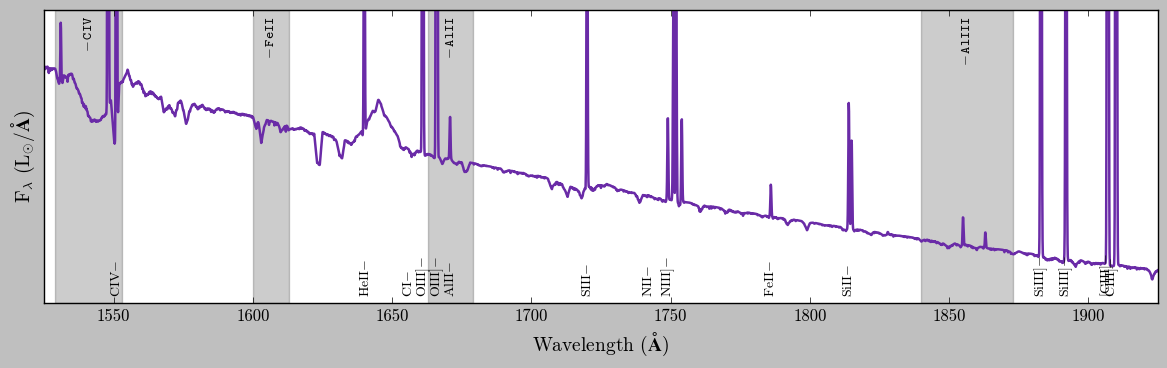

In [7]:
lims = (1525., 1925)

fig, ax = plt.subplots(1, figsize=(12,4))
col = plt.cm.CMRmap(0.3)
age = 3.0
logZ=-1.0
sfh='burst'
logU=-1.0

lam, spec = getModelSpec(logZ=logZ, logU=logU, age=age, sfh=sfh)
inds = (lam >= lims[0]) & (lam <= lims[1])
ax.plot(lam[inds], spec[inds], color=col, lw=1.8)
####
ymin = 0.9*np.min(spec[inds])
ymax = 1.5*(np.median(spec[inds]))#+0.5*np.min(spec[inds]))
ax.set_xlim(lims[0], lims[1])
ax.set_ylim(ymin, ymax)
ax.yaxis.set_major_formatter(NullFormatter())
ax.set_yticks([])
ax.set_ylabel(r'F$_{\lambda}$ (L$_{\odot}/\mathrm{\AA}$)', size=14)
plt.setp(ax.get_xticklabels(), fontsize=12)

lineinds.plotLines(ax, emission_only=False,
                    uv_sparse=True,#uv_lines=True,
                    fontsize=10)
ax.set_xlabel('Wavelength ($\mathrm{\AA}$)', size=14)
plt.tight_layout()
fig.savefig('/astro/users/ebyler/Desktop/spec.pdf')
#fig.savefig('../figs/f2.png')

# Fig.3 L+11 absorption indices for 4 Myr CSFR at logZ = -1.5, -1, -0.5, 0.0

In [8]:
flname = '/astro/users/ebyler/research/uvem/data/UVabs.dat'
data = np.genfromtxt(flname, skip_header=1, names=True, dtype=None, delimiter=',', unpack=True)
index = [dat['Index'] for dat in data]
index[1] = 'SiII_1303'
bandpass = [[float(a) for a in dat['Bandpass'].split('-')] for dat in data]
rcont = [[float(a) for a in dat['RedCont'].split('-')] for dat in data]
bcont = [[float(a) for a in dat['BlueCont'].split('-')] for dat in data]
n = len(index)

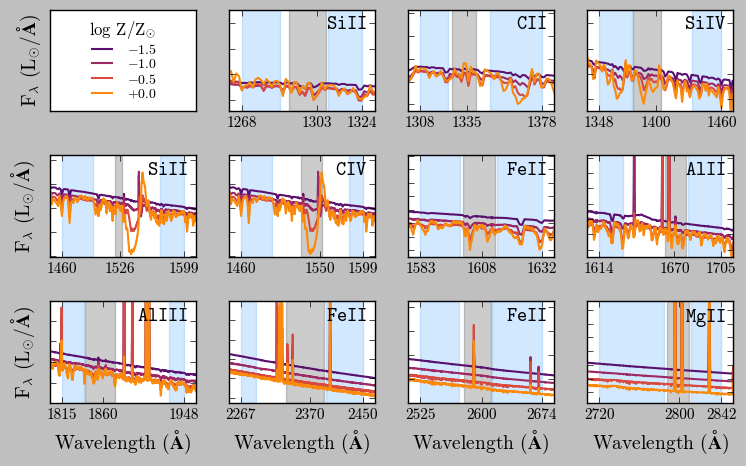

In [9]:


logZs = [-1.5, -1.0, -0.5, 0.0]
Zstrs = ['m{0:02.0f}'.format(np.abs(logZ)*10) if logZ < 0.0 else 'p{0:02.0f}'.format(np.abs(logZ)*10) for logZ in logZs]
sMz = getColors(np.linspace(-2.0,0.5),
                cname='inferno', minv=0.1, maxv=0.9)
colors = [sMz.to_rgba(z) for z in logZs]

age, sfh, logU = 4.0, 'csfr', -2.5

fig, axes = plt.subplots(3,4, figsize=(7.8,5.0))
for i in range(1,n):
    pymin, pymax = 0,0
    ax = fig.axes[i]
    for logZ, Zstr, col in zip(logZs, Zstrs, colors):
        lam, spec = getModelSpec(logZ=logZ, logU=logU,
                                 age=age,
                                 sfh=sfh)
        if Zstr[0] == 'm':
            lab = r'$-{0:.1f}$'.format(float(Zstr[1::])/10.)
        else:
            lab = r'$+{0:.1f}$'.format(float(Zstr[1::])/10.)
        ax.plot(lam, spec, color=col, lw=1.5, label=lab)
        xxmin = np.min([bcont[i][0], rcont[i][0], bandpass[i][0]])
        xxmax = np.max([bcont[i][1], rcont[i][1], bandpass[i][1]])
        buff = float('{0:.0f}'.format((xxmax-xxmin)*0.1))
        xmin, xmax = xxmin-buff, xxmax+buff
        tf = spec[(lam >= xxmin) & (lam <= xxmax)]
        ymin, ymax = 0.9*np.min(tf), 1.1*(np.median(tf)+0.5*np.min(tf)) # 1.1*np.max(tf)
        if ymax > pymax:
            pymax = ymax
        if (ymin < pymin) or (pymin == 0):
            pymin = ymin
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(pymin, pymax)
    s = index[i].replace('_', '  ')
    slab = r'$\tt{{{}}}$'.format(s.split('  ')[0])
    ax.annotate(slab,
                xy=(0.95, 0.95),ha='right',va='top',
                xycoords='axes fraction', size=14)
    ax.axvspan(bandpass[i][0], bandpass[i][1], color='k', alpha=0.2)
    ax.axvspan(bcont[i][0], bcont[i][1], color='DodgerBlue', alpha=0.2)
    ax.axvspan(rcont[i][0], rcont[i][1], color='DodgerBlue', alpha=0.2)
    xticks = [float('{0:.0f}'.format(xxmin)),
              float(index[i].split('_')[-1]),
              float('{0:.0f}'.format(xxmax))]
    xtlabs = ['{0:.0f}'.format(t) for t in xticks]
    ax.set_xticks([float('{0:.0f}'.format(xxmin)),
                   float(index[i].split('_')[-1]),
                   float('{0:.0f}'.format(xxmax))])
    ax.set_xticklabels(xtlabs)
    ax.tick_params(axis='both', labelsize=11)
    ax.yaxis.set_major_formatter(NullFormatter())
    if i == 0:
        ax.legend(loc=10, frameon=False, title=r'log Z/Z$_{\odot}$')
leg = fig.axes[0].legend(*fig.axes[1].get_legend_handles_labels(), fontsize=10,
                   loc=10, frameon=False, title=r'log Z/Z$_{\odot}$')
plt.setp(leg.get_title(), size=12)
fig.axes[0].set_xticks([])
fig.axes[0].set_yticks([])
[ax.set_ylabel(r'F$_{\lambda}$ (L$_{\odot}/\mathrm{\AA}$)', size=14) for ax in fig.axes[0::4]]
[ax.set_xlabel('Wavelength ($\mathrm{\AA}$)', size=14) for ax in fig.axes[8::]]
fig.tight_layout()
fig.savefig('../figs/f3.pdf')
fig.savefig('../figs/f3.png')


In [10]:
from matplotlib import gridspec

# Fig. 4: Al III_1860 EW with and without emission

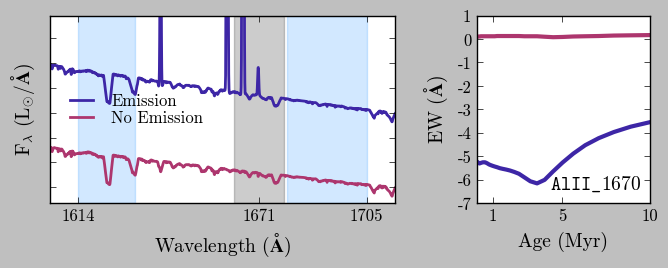

In [11]:
#----------------------------------------
#--- ITERATE THRU SFH+Z & COMPUTE EWs ---
#----------------------------------------
figsize=(7,3)
rws,cls=3,1
sfh='burst'
isochrone='mist'
EW_set='L'
logZ, Zstr = -1.0, 'm10'

colors = nColors(2, minv=0.2, maxv=0.4)
ind = 7 # Al III 1860

fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1,2,width_ratios=[2,1])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[0])

for estr, col, eax, et in zip(['e_', ''], colors, [1,2], ['Emission', 'No Emission']):
    pymin, pymax = 0,0
    dir_='/astro/users/ebyler/research/uvem/data'
    fname = dir_+'/EW/{}{}_{}_{}_EW_{}.dat'.format(estr,
                                                   isochrone,
                                                   sfh, EW_set, Zstr)
    data = np.genfromtxt(fname, delimiter=',', unpack=True, dtype=None)
    ages = data[0]
    xinds = (ages <= 7.0)
    agesMyr = (10.**ages)/1.e6
    # --- PLOT EW vs TIME ------------------
    ax = ax1
    ax.plot(agesMyr[xinds], data[ind][xinds],
            color=col, label=lab, lw=3)
    if estr == 'e_':
        s = r'$\tt{{{}}}$'.format(index[ind].replace('_','\_'))
        ax.annotate(s, xy=(0.95, 0.05),
                    xycoords='axes fraction',
                    size=14, ha='right', va='bottom')
    ax.set_xlim(agesMyr[xinds].min(), agesMyr[xinds].max())
    ax.set_xticks([1, 5, 10])   
    # --- PLOT SPECTRAL REGIONS -------------
    sfname = dir_+'/spec/{}{}_{}_{}.dat'.format(estr, isochrone, sfh, Zstr)
    sdata = np.genfromtxt(sfname, delimiter=',', unpack=True, dtype=None)
    lam, spec = sdata[0], sdata[1]
    #ax = axes[eax]
    ax = ax2
    ax.plot(lam, spec, color=col, lw=2, label=et)
    if estr != 'e_':
        xxmin = np.min([bcont[ind][0], rcont[ind][0], bandpass[ind][0]])
        xxmax = np.max([bcont[ind][1], rcont[ind][1], bandpass[ind][1]])
        buff = float('{0:.0f}'.format((xxmax-xxmin)*0.1))
        xmin, xmax = xxmin-buff, xxmax+buff
        tf = spec[(lam >= xxmin) & (lam <= xxmax)]
        ymin, ymax = 0.9*np.min(tf), 1.1*np.max(tf)
        if ymax > pymax:
            pymax = ymax
        if (ymin < pymin) or (pymin == 0):
            pymin = ymin
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(pymin, pymax)
        if logZ == 0.0:
            ax.axvspan(bandpass[ind][0], bandpass[ind][1], color='k', alpha=0.2)
            ax.axvspan(bcont[ind][0], bcont[ind][1], color='b', alpha=0.2)
            ax.axvspan(rcont[ind][0], rcont[ind][1], color='b', alpha=0.2)
        xtks = [xxmin, np.median([bandpass[ind][0], bandpass[ind][1]]), xxmax]
        xtklabs = ['{0:.0f}'.format(t) for t in xtks]
        ax.set_xticks(xtks)
        ax.set_xticklabels(xtklabs)
        ax.yaxis.set_major_formatter(NullFormatter())
yy = ax2.get_ylim()
ax2.set_ylim(yy[0], yy[1]*1.5)
ax2.set_ylabel(r'F$_{\lambda}$ (L$_{\odot}/\mathrm{\AA}$)', size=14)
ax2.set_xlabel('Wavelength ($\mathrm{\AA}$)', size=14)
ax1.set_ylabel(r'EW ($\mathrm{\AA}$)', size=14)
ax1.set_xlabel(r'Age (Myr)', size=14)
ax2.axvspan(bandpass[ind][0], bandpass[ind][1], color='k', alpha=0.2)
ax2.axvspan(bcont[ind][0], bcont[ind][1], color='DodgerBlue', alpha=0.2)
ax2.axvspan(rcont[ind][0], rcont[ind][1], color='DodgerBlue', alpha=0.2)
[plt.setp(ax.get_xticklabels(), fontsize=12) for ax in [ax1,ax2]]
[plt.setp(ax.get_yticklabels(), fontsize=12) for ax in [ax1,ax2]]
plt.legend(loc=6, frameon=False, fontsize=12)
plt.tight_layout()
fig.savefig('../figs/f4.pdf')
fig.savefig('../figs/f4.png')

In [12]:
def grab_absLines(logZ=0.0, age=1.0, logU=-2.0, return_time=False, line_index=5,
                  isochrone='mist', sfh='burst', lineset='L', logt=False, tempFix=False):
    '''
    returns the 11 Leitherer absorption line indices for the specified parameters
    '''
    #logZs = [-1.0, -0.5, 0.0, 0.5]
    #if logZ not in logZs:
    #    return np.full(11, np.nan)
    Zstr = 'm{0:02.0f}'.format(np.abs(logZ)*10) if logZ < 0.0 else 'p{0:02.0f}'.format(np.abs(logZ)*10)
    Ustr = 'logU_{0:.1f}_'.format(logU*-1)
    dir_='/astro/users/ebyler/research/uvem/data'
    subdir='AbsEmData'
    subdir='EW'
    estr='e_'
    fname = dir_+'/{}/{}{}_{}_{}_EW_{}.dat'.format(subdir, estr, #Ustr,
                                                                isochrone,
                                                                sfh,
                                                                lineset,
                                                                Zstr)
    try:
        data = np.genfromtxt(fname, delimiter=',', unpack=True, dtype=None)
    except:
        print '{} does not exist'.format(fname.split('/')[-1])
        return np.full(11, np.nan)
    
    data = np.genfromtxt(fname, delimiter=',', unpack=True, dtype=None)
    ages = data[0]
    if tempFix:
        ages = np.arange(5., 7.10, 0.05)
    agesMyr = (10.**ages)/1.e6
    if return_time:
        if logt:
            outage = ages
        else:
            outage = agesMyr
        return (outage, data[1::][line_index])
    else:
        age_ind = np.argmin(np.abs(agesMyr - age))
        return data[1::, age_ind]

# Fig.5: EW vs. time (burst, csfr; at logZ = -1.5, -1.0, -0.5, 0.0

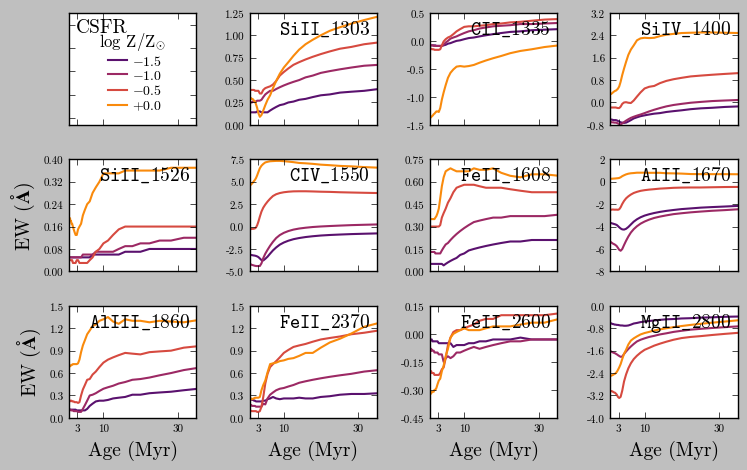

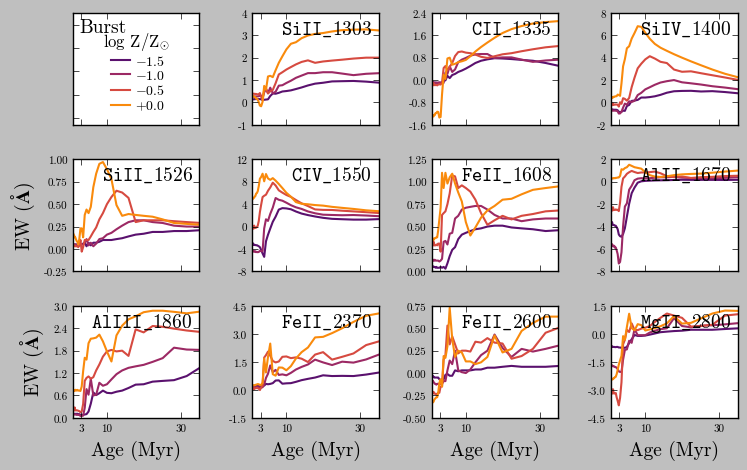

In [13]:
###
logZs = [-1.5, -1.0, -0.5, 0.0]
Zstrs = ['m{0:02.0f}'.format(np.abs(logZ)*10) if logZ < 0.0 else 'p{0:02.0f}'.format(np.abs(logZ)*10) for logZ in logZs]
sMz = getColors(np.linspace(-2.0, 0.5),cname='inferno', maxv=0.9, minv=0.1)
###
sfhs=['burst', 'csfr']
anlabs = ['CSFR', 'Burst'] # accidentally got file names backwards
figlabels = ['a', 'b']
isochrone='mist'
logU = -1.0
###
for sfh, figlabel, anlabel in zip(sfhs, figlabels, anlabs):
    z_handles = []
    z_labs = []
    fig, axes = plt.subplots(3,4, figsize=(7.8,5.0), sharex=True)
    for logZ, Zstr in zip(logZs, Zstrs):
        col = sMz.to_rgba(logZ)
        for i in range(1,n):
            ax = fig.axes[i]
            agesMyr, EWs = grab_absLines(logZ=logZ, return_time=True,
                                         line_index=i-1, logU=logU,
                                         sfh=sfh, logt=False)
            lab = '$-{0:.1f}$'.format(float(Zstr[1::])/10.) if Zstr[0] == 'm' else '$+{0:.1f}$'.format(float(Zstr[1::])/10.)
            alim = (0.8, 35.0)
            ais = (agesMyr <= alim[1]+5.0) & (agesMyr >= alim[0])
            handles, = ax.plot(agesMyr[ais], EWs[ais],
                               color=col, label=lab, lw=1.5)
            if i > 0:
                s = index[i].replace('_', '  ')
                slab = r'$\tt{{{}}}$'.format(index[i].replace('_', '\_'))
                if logZ == logZs[0]:
                    ax.annotate(slab, xy=(0.95, 0.95),
                                xycoords='axes fraction',
                                size=14, ha='right', va='top')
            #ax.set_xlim(agesMyr.min(), agesMyr.max())
            ax.set_xlim(alim)
            ax.set_xticks([3, 10, 30])
            ax.yaxis.set_major_locator(plt.MaxNLocator(5))
            ax.tick_params(axis='both', labelsize=8)
        z_handles.append(handles)
        z_labs.append(lab)
    fig.axes[0].annotate('{}'.format(anlabel), xy=(0.05, 0.95), xycoords='axes fraction',
                         size=14, ha='left', va='top')
    leg = fig.axes[0].legend(z_handles, z_labs, loc=8, frameon=False,
                       title=r'log Z/Z$_{\odot}$', fontsize=10,
                       handletextpad=0.05, labelspacing=0.1)
    plt.setp(leg.get_title(), fontsize=12)
    fig.axes[0].set_ylim(-0.3,4.5)
    plt.setp(fig.axes[0].yaxis.get_ticklabels(), visible=False)
    [plt.setp(ax.xaxis.get_ticklabels(), visible=False) for ax in fig.axes[0:7]]
    [ax.set_ylabel(r'EW ($\mathrm{\AA}$)', size=14) for ax in fig.axes[0::4]]
    [ax.set_xlabel(r'Age (Myr)', size=14) for ax in fig.axes[8::]]
    fig.axes[0].set_ylabel(' ')
    fig.tight_layout()
    fig.savefig('../figs/f5{}.pdf'.format(figlabel))
    fig.savefig('../figs/f5{}.png'.format(figlabel))

In [14]:
def getModelEWs(logZ=-0.5, logU=-2.0, age=4.0,
                return_time=False, logt=True, return_Q=True):
    '''
    returns the 11 Leitherer absorption line indices
    for the specified parameters
    ages, logQHs, logQHes, EWs = getModelEWs(return_Q=True)
    '''
    dir_='/astro/users/ebyler/research/pagb/data/'
    if logZ < 0.0:
        logZstr = 'm{0:02.0f}'.format(np.abs(logZ)*10)
    else:
        logZstr = 'p{0:02.0f}'.format(np.abs(logZ)*10)
    logUstr = 'logU_{0:.1f}'.format(logU*-1)
    flname = '{}{}_{}_EW.dat'.format(dir_, logUstr, logZstr)
    try:
        data = np.genfromtxt(flname, delimiter=',',
                             unpack=True, dtype=None)
    except:
        #print '{} does not exist'.format(fname.split('/')[-1])
        return np.full(1, np.nan)
    data = np.genfromtxt(flname, delimiter=',',
                         unpack=True, dtype=None)
    agesMyr = (10.**data[0])/1.e6
    if return_time:
        if logt:
            outage = data[0]
        else:
            outage = agesMyr
        if return_Q:
            return (outage, data[1::][0], data[1::][1], data[1::][-1])
        else:
            return (outage, data[1::][-1])
    else:
        age_ind = np.argmin(np.abs(agesMyr - age))
        if return_Q:
            return data[1::][0][age_ind], data[1::][1][age_ind]
        else:
            return data[1::, age_ind]

def appendQs(mod, subdir='uvem'):
    '''
    returns the 11 Leitherer absorption line indices
    for the specified parameters
    ages, logQHs, logQHes, EWs = getModelEWs(return_Q=True)
    '''
    logZs = [-2.0, -1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25]
    QHs = np.ones_like(mod.age)
    for i in range(mod.nmods):
        if mod.logZ[i] in logZs:
            logQH, logQHe = getModelEWs(logZ=mod.logZ[i],
                                        logU=mod.logU[i],
                                        age=mod.age[i]/1.e6,
                                        return_Q=True, return_time=False)
            QHs[i] *= 10.**logQH
        else:
            QHs[i] = np.nan
    mod.__setattr__('QHs', QHs)
    return

def getLineLum(mod=None, line='Ha', normalize_line=False, line2=None, logify=False,
               logU=-2.0, age=1.0, sfh='burst',
               subdir='uvem'):
    '''
    returns the 11 Leitherer absorption line indices
    for the specified parameters
    ages, logQHs, logQHes, EWs = getModelEWs(return_Q=True)
    '''
    if mod is None:
        dir_='/astro/users/ebyler/research/{}/data/'.format(subdir)
        if sfh == 'CSFR':
            fname = dir_+'ZAU_CSFR_ext_b_lum.lines'
        else:
            fname = dir_+'ZAU_ext_b_lum.lines'
        mod = modObj(fname)
    logZs =  [-2.0, -1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25]
    lums = []
    Qs, QHs, QHes = [], [], []
    for logZ in logZs:
        ind = np.where((mod.age == age*1.e6) & \
                       (mod.logU == logU) & \
                       (mod.logZ == logZ))[0][0]
        lum = mod.__getattribute__(line)[ind]
        Q = 10.**mod.logQ[ind]
        logQH, logQHe = getModelEWs(logZ=logZ, logU=logU, age=age,
                                    return_Q=True, return_time=False)
        QH, QHe = pow(10., logQH), pow(10., logQHe)
        norm_val = Q/QH
        QHs.append(QH)
        QHes.append(QHe)
        Qs.append(Q)
        if line2 is not None:
            lum /= mod.__getattribute__(line2)[ind]
        else:
            if normalize_line:
                lum /= norm_val
        if logify:
            lums.append(np.log10(lum))
        else:
            lums.append(lum)
    return logZs, np.array(lums)

In [15]:
sfh='burst'
if sfh=='burst':
    fname = '/astro/users/ebyler/research/uvem/data/ZAU_ext_b_lum.lines'
else:
    fname = '/astro/users/ebyler/research/uvem/data/ZAU_CSFR_ext_b_lum.lines'
zau = modObj(fname)

uvdat = np.genfromtxt('/astro/users/ebyler/research/uvem/local_emLines.dat', delimiter='\t', dtype=None)
ulines = []
ulined = {}
i=0
for u in uvdat:
        oname = u[0].replace('[', '').replace(']', '').replace('-', '').replace('$', '').replace('\\','_')
        if oname[0:2] not in ['HI', 'Br', 'Ly', 'Pa', 'Ba', 'PI', 'P5', 'P6', 'P7', 'P8', 'H5','H6','H7','H8', 'Pf', 'Hu', 'H_']:
            float_lambda = float(u[1])
            if (float_lambda < 3900.0) & (float_lambda > 1220.):
                i += 1
                wl = int(u[1])
                lam = u[1]
                dname = '{}_{}'.format(oname, wl)
                if dname in ulined.keys():
                    suff = '{0:.2f}'.format(lam)
                    dname = '{}_{}'.format(oname, suff.replace('.', '_'))
                ulines.append((dname, lam))
                ulined[dname] = lam
zau.add_lines(ulined)
#for lines, name in zip(ratio_lines, ratio_names):
#    arr = np.log10(zau.__getattribute__(lines[0])/zau.__getattribute__(lines[1]))
#    zau.__setattr__(name, arr)

logZs = [-2.0, -1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25]
logUs = [-4.0, -3.0, -2.0, -1.0]
ages = zau.age_vals[1::]
QHs = np.ones_like(zau.age)
for i in range(zau.nmods):
    if (zau.logZ[i] in logZs) & (zau.age[i] in ages) & (zau.logU[i] in logUs):
        logQH, logQHe = getModelEWs(logZ=zau.logZ[i],
                                    logU=zau.logU[i],
                                    age=zau.age[i]/1.e6,
                                    return_Q=True, return_time=False)
        QHs[i] *= 10.**logQH
    else:
        QHs[i] = np.nan
zau.__setattr__('QHs', QHs)

In [16]:
def upxl_plot(zau, logU=-2.5, ax=None, do_label=False,
             zname='log_NIIb_Ha', # line ratios to plot
             cb_label='log[ N II/ Ha ]', # line ratios to plot
             grid_xname='age', grid_yname='logZ', # grids in logU and log Z
             xlim=(-2.0, 1.0), ylim=(-2.0, 1.0), # axis limits
             cname='inferno', xv=(0.2, 1.0), yv=(0.2, 0.9), # color properties
             lw=4, alpha=1.0, # line properties
             xclims=(0.5e6, 10.e6), yclims=(-2.0, 0.5),
             cmap=None, sM=None, cNorm=None, cb_arr=None,
             no_cbar=False, show_grid=False, aspect='auto',
             xlabels=None, ylabels=None,
             xax_lab=None, yax_lab=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1)
    #####
    # calculate grid
    #####
    use_inds = [i for i in range(zau.nmods) if ((zau.logU[i] == logU) and \
                                                (zau.__getattribute__(grid_xname)[i] >= xclims[0]) and \
                                                (zau.__getattribute__(grid_xname)[i] <= xclims[1]) and \
                                                (zau.__getattribute__(grid_yname)[i] >= yclims[0]) and \
                                                (zau.__getattribute__(grid_yname)[i] <= yclims[1]))]
    grid_x = np.array([x for x in zau.__getattribute__(grid_xname+'_vals') if (x >= xclims[0]) & (x <= xclims[1])])
    grid_y = np.array([y for y in zau.__getattribute__(grid_yname+'_vals') if (y >= yclims[0]) & (y <= yclims[1])])
    X, Y = np.meshgrid(grid_x, grid_y)
    Z = np.zeros_like(X)
    for index, x in np.ndenumerate(Z):
        mind = [i for i in use_inds
                if (zau.__getattribute__(grid_xname)[i] == X[index]
                    and zau.__getattribute__(grid_yname)[i] == Y[index])]
        try:
            Z[index] = zau.__getattribute__(zname)[mind[0]]
        except AttributeError:
            print('not a valid attribute.')
    masked_array = np.ma.array(Z, mask=np.isnan(Z))
    ####
    # 
    ####
    if grid_xname == 'age':
        X*=1.0e-6
    if grid_yname == 'age':
        Y*=1.0e-6
    ####
    # color bar crap
    ####
    if (sM is None) or (cNorm is None):
        if cb_arr is not None:
            arr_in = cb_arr
        else:
            arr_in = masked_array
        if cmap is not None:
            sM, cNorm = getColors(arr_in, return_cNorm=True,
                                  set_bad_vals=True, cmap=cmap)
        else:
            sM, cNorm = getColors(arr_in, return_cNorm=True,
                                  set_bad_vals=True, cname=cname)
        cmap = plt.get_cmap(cname)
    pf = ax.imshow(Z, norm=cNorm, aspect=aspect,
                   interpolation='nearest', origin='lower',
                   cmap=cmap)
    xCenters = X[0]
    yCenters = Y[:,0]
    if xlabels is None:
        xlabels = ['{0:.0f}'.format(x) for x in xCenters]
    if ylabels is None:
        ylabels = ['{0:.1f}'.format(y) for y in yCenters]
    for axis, labels in zip([ax.xaxis, ax.yaxis], [xlabels, ylabels]):
        locs = np.arange(len(labels))
        axis.set_ticks(locs + 0.5, minor=True)
        axis.set(ticks=locs, ticklabels=labels)
    if show_grid:
        ax.grid(True, which='minor')
    if xax_lab is None:
        xax_lab = grid_xname
        yax_lab = grid_yname
    ax.set_xlabel(xax_lab, size=14)
    ax.set_ylabel(yax_lab, size=14)
    if no_cbar:
        return pf
    else:
        cb = plt.colorbar(pf, ax=ax)
        if cb_label is not None:
            cb_lab_size=kwargs.get('cb_lab_size', 12)
            cb.set_label(cb_label, size=cb_lab_size)
        return ax

# Fig. 6: time evolution of Halpha emission

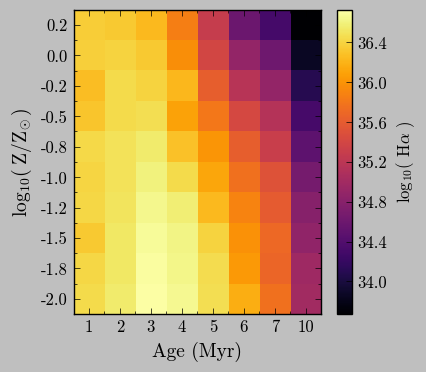

In [17]:
label = r'$\log_{10}$( H$\alpha$ )'
line = 'Ha'

norms = (10.**zau.logQ)/zau.QHs
arr = zau.__getattribute__(line)
zau.__setattr__('norm_'+line, np.log10(arr/norms))

ylabel=r'$\log_{10}(\;$Z/Z$_{\odot}\,$)'
xlabel=r'Age (Myr)'
logU = -2.0

fig,ax = plt.subplots(1, figsize=(4.5,4))
upxl_plot(zau, logU=logU, ax=ax, zname='norm_'+line, cb_label=label,
          xax_lab=xlabel, yax_lab=ylabel, yclims=(-2.0,0.25),
          xclims=(1.e6,10.e6),
          grid_xname='age')
fig.tight_layout()
fig.savefig('../figs/f6.pdf')
fig.savefig('../figs/f6.png')

In [41]:
linefile='/astro/users/ebyler/research/uvem/data/ZAU_CSFR_ext_b_lum.lines'
zau = modObj(linefile)
zau.gas_logZ = zau.logZ + 12. + -3.31

In [42]:
uvdat = np.genfromtxt('/astro/users/ebyler/research/uvem/local_emLines.dat', delimiter='\t', dtype=None)

ulines = []
ulined = {}
i = 0
k = 0
m = 0
for u in uvdat:
        oname = u[0].replace('[', '').replace(']', '').replace('-', '').replace('$', '').replace('\\','_')
        if oname[0:2] not in ['HI', 'Br', 'Ly', 'Pa', 'Ba', 'PI', 'P5', 'P6', 'P7', 'P8', 'H5','H6','H7','H8', 'Pf', 'Hu', 'H_']:
            float_lambda = float(u[1])
            if (float_lambda < 3900.0) & (float_lambda > 1220.):
                i += 1
                wl = int(u[1])
                lam = u[1]
                dname = '{}_{}'.format(oname, wl)
                if dname in ulined.keys():
                    suff = '{0:.2f}'.format(lam)
                    dname = '{}_{}'.format(oname, suff.replace('.', '_'))
                ulines.append((dname, lam))
                ulined[dname] = lam
            else:
                k+=1
        else:
            m+=1

print i, k, m, uvdat.shape
print i+k+m
zau.add_lines(ulined)
for line in ulined.keys():
    nkey = 'log_'+line+'_Hb'
    nkey_arr = np.log10(zau.__getattribute__(line)/zau.Hb)
    line_arr = zau.__getattribute__(line)
    zau.__setattr__(nkey, nkey_arr)
    zau.__setattr__(line, line_arr)

57 29 2 (88,)
88


In [43]:
age = 4.0e6
logU = -2.5
zmin, zmax = -1.5, 0.0
mod_inds = (zau.logU == logU) & (zau.age == age) & (zau.logZ >= zmin) & (zau.logZ <= zmax)

rlines = {}
i=0
for line in ulined.keys():
    val = np.max(zau.__getattribute__('log_'+line+'_Hb')[mod_inds])
    if val >= -4.0:
        if 'He' not in line:
            rlines[line] = ulined[line]
            i+=1
print 'lines with log(F / Hbeta) > 4: ', i

lines with log(F / Hbeta) > 4:  45


# Fig.7: emission line strength vs. variance

### 7 (a) metallicity for model at logU=-2.5, 4 Myr CSFR

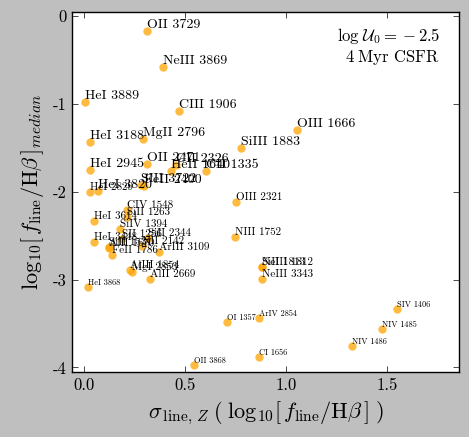

In [44]:
zlims = (-1.5, 0.25)
age = 4.0e6
logU = -2.5
zau.med_LineDict = {}
zau.std_LineDict = {}
for line in ulined.keys():
    nkey = 'log_'+line+'_Hb'
    # FIXED LOGU=-2.5 AND AGE=4MYR
    inds = (zau.logZ >= zlims[0]) & (zau.logZ <= zlims[1]) & (zau.age == age) & (zau.logU == logU)
    arr = zau.__getattribute__(nkey)[inds]
    median_ratio = np.median(arr)
    sigma_ratio = np.std(arr)
    zau.med_LineDict[nkey] = median_ratio
    zau.std_LineDict[nkey] = sigma_ratio
####
fig, ax = plt.subplots(1,figsize=(5,4.5))
####
for key,med in zau.med_LineDict.items():
    std = zau.std_LineDict[key]
    lab = ' '.join([key.split('_')[1], key.split('_')[2]])
    ax.plot(std, med, 'o', color='orange', markeredgecolor='None', alpha=0.75)
    if (med <= -3.0):
        size=6
    elif (med <= -2.0) & (med > -3.0) & (std < 1.0):
        size=8
    else:
        size=10
    ax.annotate(lab, xy=(std, med), fontsize=size,
                xycoords='data', ha='left', va='bottom')
ax.annotate(r'log$\;\mathcal{{U}}_0={0:.1f}$'.format(logU),
            xy=(0.95,0.96), xycoords='axes fraction',
            size=12,ha='right', va='top')
ax.annotate(r'${0:.0f}\;$Myr CSFR'.format(age*1.e-6),
            xy=(0.95,0.9), xycoords='axes fraction',
            size=12,ha='right', va='top')
ax.set_xlabel(r'$\sigma_{\,\mathrm{line,\,}Z}\;(\;\log_{10} [\,f_{\mathrm{line}}/\mathrm{H}\beta\,]\;)$', size=16)
ax.set_ylabel(r'$\log_{10} [\,f_{\mathrm{line}}/\mathrm{H}\beta\,]_{median}$', size=16)
ax.set_ylim(-4.05, 0.05)#-0.85)
ax.set_xlim(-0.06, 1.86)
fig.savefig('../figs/f7a.pdf')
fig.savefig('../figs/f7a.png')

### 7 (b): variance due to logU for model at logZ = -0.5, 4 Myr CSFR

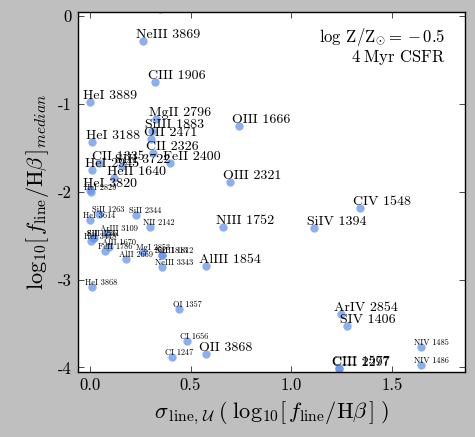

In [45]:
age = 4.0e6
logZ = -0.5
zau.med_LineDict = {}
zau.std_LineDict = {}
for line in ulined.keys():
    nkey = 'log_'+line+'_Hb'
    # FIXED LOGZ=-0.5 AND AGE=2MYR
    inds = (zau.logZ == logZ) & (zau.age == age)
    arr = zau.__getattribute__(nkey)[inds]
    median_ratio = np.median(arr)
    sigma_ratio = np.std(arr)
    zau.med_LineDict[nkey] = median_ratio
    zau.std_LineDict[nkey] = sigma_ratio
    
fig, ax = plt.subplots(1,figsize=(5,4.5))
for key,med in zau.med_LineDict.items():
    std = zau.std_LineDict[key]
    lab = ' '.join([key.split('_')[1], key.split('_')[2]])
    ax.plot(std, med, 'o', color='CornflowerBlue', markeredgecolor='None', alpha=0.75)
    if (std < 0.5) & (med <= -2.0):
        size=6
    elif std >= 1.5:
        size=6
    else:
        size=10
    ax.annotate(lab, xy=(std, med), xytext=(-5,0),
                xycoords='data', textcoords='offset points',
                ha='left', va='bottom', fontsize=size)

ax.annotate(r'log Z/Z$_{{\odot}}={0:.1f}$'.format(logZ),
            xy=(0.95,0.96), xycoords='axes fraction',
            size=12,ha='right', va='top')
ax.annotate(r'${0:.0f}\;$Myr CSFR'.format(age*1.e-6),
            xy=(0.95,0.9), xycoords='axes fraction',
            size=12,ha='right', va='top')
ax.set_xlabel(r'$\sigma_{\,\mathrm{line,\,}\mathcal{U}}\;(\;\log_{10} [\,f_{\mathrm{line}}/\mathrm{H}\beta\,]\;)$', size=16)
ax.set_ylabel(r'$\log_{10} [\,f_{\mathrm{line}}/\mathrm{H}\beta\,]_{median}$', size=16)
ax.set_ylim(-4.05, 0.05)
ax.set_xlim(-0.06, 1.86)
fig.savefig('../figs/f7b.pdf')
fig.savefig('../figs/f7b.png')

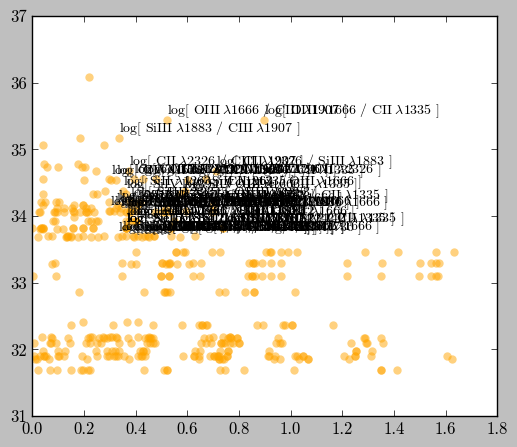

In [46]:
age = 4.0e6
logU = -2.5
zmin, zmax = -2.0, 0.0
mod_inds = (zau.logU == logU) & (zau.age == age) & (zau.logZ >= zmin) & (zau.logZ <= zmax)

lines = np.array(rlines.keys())
wavs = np.array(rlines.values())
sinds = np.argsort(wavs)

fig, ax = plt.subplots(1, figsize=(6,5))
best_x = []
best_y = []
best_l = []
best_w = []
best_n = []
for i_ind, ii in enumerate(sinds):
    line = lines[ii]
    wav = wavs[ii]
    ratio_names = []
    ratio_meds = []
    ratio_stds = []
    ratio_labels = []
    ratio_dists = []
    ratio_diffs = []
    for i, si in enumerate(sinds):
        iline = lines[si]
        iwav = wavs[si]
        #if (iline != line) & (wav < iwav):
        if (i_ind < i):
            line_arr = zau.__getattribute__(line)[mod_inds]
            iline_arr = zau.__getattribute__(iline)[mod_inds]
            if np.max(line_arr) > np.max(iline_arr):
                # if line is more luminous, it goes on bottom
                top, twav = iline, iwav
                bot, bwav = line, wav
                top_arr = iline_arr
                bot_arr = line_arr
            else:
                top, twav = line, wav
                bot, bwav = iline, iwav
                top_arr = line_arr
                bot_arr = iline_arr
            ###
            wav_diff = np.abs(twav - bwav)
            if wav_diff <= 500.:
                ratio_name = '_'.join(['log', top, bot])
                #print ratio_name
                tt = top.split('_')[0]
                bb = bot.split('_')[0]
                ratio_label = r'log[ {0}$\;\lambda${1:.0f} / {2}$\;\lambda${3:.0f} ]'.format(tt, twav, bb, bwav)
                ratio_arr = np.log10(top_arr/bot_arr)
                #
                med = np.median(np.log10(top_arr)) ## using median lum
                std = np.std(ratio_arr)
                #
                ratio_names.append(ratio_name)
                ratio_labels.append(ratio_label)
                ratio_meds.append(med)
                ratio_stds.append(std)
                ratio_diffs.append(wav_diff)
    wav_diffs = np.array(ratio_diffs)
    xarr = np.array(ratio_stds)
    yarr = np.array(ratio_meds)
    labs = np.array(ratio_labels)
    ax.plot(xarr, yarr, 'o', color='orange', markeredgecolor='None', alpha=0.5)
    [ax.annotate(lab, xy=(x,y),
                 fontsize=10, xycoords='data',
                 ha='left', va='bottom')
     for lab,x,y in zip(labs, xarr, yarr) if (x > 0.3) & (y > 33.5)]
    [best_x.append(x) for x in xarr]
    [best_y.append(y) for y in yarr]
    [best_l.append(l) for l in labs]
    [best_w.append(w) for w in wav_diffs]
    [best_n.append(n) for n in ratio_names]
#fig.savefig('./figs/ratio_grids/{}.png'.format(line))

# Fig.8: emission line strength vs. emission line variance

### variance due to Z for model with 4 Myr CSFR and logU=-2.5

419 38
[  0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5
  12.5  13.5]


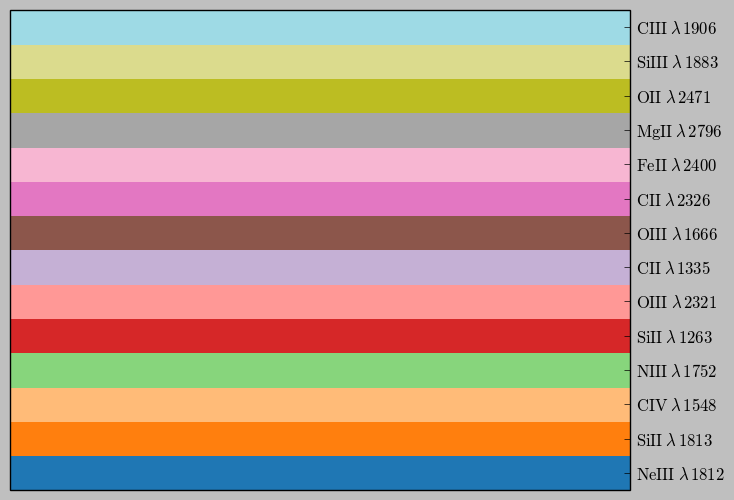

In [49]:
#
xarr, yarr = np.array(best_x), np.array(best_y)
larr, warr = np.array(best_l), np.array(best_w)
narr = np.array(best_n)
#

#ylims = (33.5, 36.0)
ylims = (34.0, 35.6)
xlims = (0.3, 0.75)
yinds = (yarr >= ylims[0]) & (yarr < ylims[1]) & (xarr >= xlims[0]) & (xarr <= xlims[1])
yis, = np.nonzero(yinds)
print len(xarr), len(yis)

all_names = narr[yis]
all_ys = yarr[yis]
all_denom_names = np.array(['_'.join(all_names[i].split('_')[-2::]) for i in range(len(all_names))])
unsorted_denom_names = np.unique(all_denom_names)

unsorted_denom_ys = np.zeros(len(unsorted_denom_names))
for i in range(len(all_names)):
    full_ratio_name = all_names[i]
    yval = all_ys[i]
    denom_name = all_denom_names[i]
    ii = np.where(unsorted_denom_names == denom_name)[0][0]
    if yval > unsorted_denom_ys[ii]:
        unsorted_denom_ys[ii] = yval

unsorted_denom_wls = np.array([float(unsorted_denom_names[i].split('_')[-1]) for i in range(len(unsorted_denom_names))])
swli = np.argsort(unsorted_denom_wls)
swli = np.argsort(unsorted_denom_ys)
denom_names = unsorted_denom_names[swli]
snames = np.array([denom_names[i].replace('_',r'$\;\lambda\,$') for i in range(len(denom_names))])
nbounds = len(denom_names)+1
bounds = np.arange(0,nbounds,1)
# location of line labels
tick_locs = bounds[0:-1]+0.5
print tick_locs
#create colormap
#cols = nColors(nbounds, cname='Set2', minv=0.0, maxv=1.0)
sM = getColors(np.arange(0, nbounds, 1), cname='Vega20', minv=0.0, maxv=1.0)
cols = [sM.to_rgba(i) for i in tick_locs]

cmap = mpl.colors.ListedColormap(cols)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cdict = {}
for i in range(len(all_names)):
    full_ratio_name = all_names[i]
    yval = all_ys[i]
    denom_name = all_denom_names[i]
    ii = np.where(denom_names == denom_name)[0][0]
    cdict[full_ratio_name] = cols[ii]


#plot
fig, ax = plt.subplots()

cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm,
                               ticks=tick_locs,
                               spacing='proportional',
                               orientation='vertical')
cb.set_ticklabels(snames)


array([ 34.16298237,  34.53832233,  34.08303654,  34.53832233,
        34.12596896,  34.0652435 ,  34.0652435 ,  34.6742915 ,
        35.43702084,  34.210265  ,  34.55299655,  34.55299655,
        34.55299655,  34.55299655])

419 38
[  0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5
  12.5  13.5]


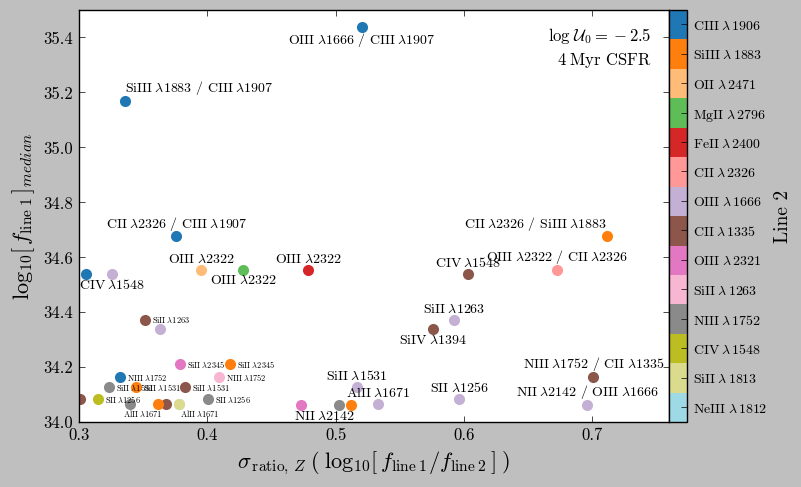

In [60]:
#
xarr, yarr = np.array(best_x), np.array(best_y)
larr, warr = np.array(best_l), np.array(best_w)
narr = np.array(best_n)
#
#ylims = (33.5, 36.0)
ylims = (34.0, 35.5)
xlims = (0.3, 0.76)
yinds = (yarr >= ylims[0]) & (yarr < ylims[1]) & (xarr >= xlims[0]) & (xarr <= xlims[1])
yis, = np.nonzero(yinds)
print len(xarr), len(yis)
# grabbing colorbar names
all_names = narr[yis]
all_ys = yarr[yis]
all_denom_names = np.array(['_'.join(all_names[i].split('_')[-2::]) for i in range(len(all_names))])
unsorted_denom_names = np.unique(all_denom_names)
# sorting on y-value
unsorted_denom_ys = np.zeros(len(unsorted_denom_names))
for i in range(len(all_names)):
    full_ratio_name = all_names[i]
    yval = all_ys[i]
    denom_name = all_denom_names[i]
    ii = np.where(unsorted_denom_names == denom_name)[0][0]
    if yval > unsorted_denom_ys[ii]:
        unsorted_denom_ys[ii] = yval
unsorted_denom_wls = np.array([float(unsorted_denom_names[i].split('_')[-1]) for i in range(len(unsorted_denom_names))])
#swli = np.argsort(unsorted_denom_wls) # sorting on y val now
swli = np.argsort(unsorted_denom_ys)
denom_names = unsorted_denom_names[swli]
snames = np.array([denom_names[i].replace('_',r'$\;\lambda\,$') for i in range(len(denom_names))])
nbounds = len(denom_names)+1

# location of line labels
tick_locs = bounds[0:-1]+0.5
print tick_locs
#create colormap
#cols = nColors(nbounds, cname='Set2', minv=0.0, maxv=1.0)
sM = getColors(np.arange(0, nbounds, 1), cname='Vega20_r', minv=0.0, maxv=1.0)
cols = [sM.to_rgba(i) for i in tick_locs]
cmap = mpl.colors.ListedColormap(cols)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cdict = {}
for i in range(len(all_names)):
    full_ratio_name = all_names[i]
    denom_name = all_denom_names[i]
    ii = np.where(denom_names == denom_name)[0][0]
    cdict[full_ratio_name] = cols[ii]

fig, (ax, cax) = plt.subplots(1,2, figsize=(8,4.85), gridspec_kw={"width_ratios":[1, 0.03]})

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                               ticks=tick_locs,
                               spacing='proportional',
                               orientation='vertical')
cb.set_ticklabels(snames)
cb.ax.tick_params(labelsize=10)
cb.set_label('Line 2', size=14)
for yi in yis:
    x,y,l,n = xarr[yi], yarr[yi], larr[yi], narr[yi]
    
    color = cdict[n]
    la = l.strip('log[ ').split(' / ')[0]
    ax.plot(x, y, 'o', markersize=8,
            color=color, markeredgecolor='None', alpha=1.0)
    xo = 0
    yo = 3
    ha = 'center'
    va = 'bottom'
    fontsize=10
    
    if y > 35.3:
        va='top'
        yo=-3
    if (x <= 0.45) & (y <= 34.4):
        fontsize=6
        ha='left'
        xo=5
        va='center'
        yo=0
        if (x < 0.305) & (la[-4::] == '1256'):
            la=''
    if y < 33.8:
        if (x < 0.5) & (x > 0.45):
            va='bottom'
            yo = np.random.randint(0, 10)
        elif x <= 0.45:
            #va='top'
            yo = np.random.randint(-15, 0)
    if x > 0.71:
        ha = 'right'
        if y <= 34.0:
            print la
            print x
            if la[-1] == '2':
                va = 'top'
                yo = -3
            else:
                yo = 5
    if (la[-4::] == '1394'):
        if x < 0.4:
            ha='left'
            yo=0
        else:
            va='top'
            yo=-3
    if (la[-4::] == '2142'):
        if (x < 0.55) & (y < 34.2):
            if x < 0.5:
                la = ''
            elif x >= 0.51:
                la = ''
            else:
                va='top'
                yo=-3
                xo=-10
    if (la[-4::] == '1671'):
        if (x < 0.38) & (y < 34.2):
            if x < 0.34:
                va='top'
                yo=-3
                xo=-5
            elif x > 0.37:
                la=''
            elif x < 0.365:
                la=''
            else:
                va='top'
                yo=-3
                xo=10
    if (la[-4::] == '1548'):
        if x < 0.35:
            if x <0.31:
                la=''
            else:
                va='top'
                yo=-3
                xo=0
    if (la[-4::] == '2322'):
        if (y < 34.6) & (y > 34.4):
            if (x > 0.42) & (x <= 0.44):
                va='top'
                yo=-3
    if (x < 0.6) & (y < 34.6):
        if (la[-4::] == '1394'):
            if (x > 0.4) & (x < 0.49):
                la=''
            if (x < 0.4) & (x >= 0.35):
                la=' '
            elif (x <= 0.35):
                va='top'
                yo=-3
        elif la[-4::] == '1786':
            if x > 0.5:
                va='top'
                yo=-3
        elif la[-4::] == '2142':
            if x >= 0.56:
                la = ' '
        #elif la[-4::] == '1256':
        #    va='top'
        #    yo=-3
    if (x <= 0.5) & (y < 34.6):
        if (la[-4::] == '1548'):
            if (x > 0.4) & (x < 0.45):
                la=' '
        if (la[-4::] == '2322'):
            ha='center'
            xo=0
            if x > 0.48:
                la=' '
        if (la[-4::] == '1394'):
            if (x < 0.5) & (x > 0.4):
                la = ' '
    if (y >= 34.6):
        if la[-4::] == '1883':
            ha='left'
            xo=0
        la = l.strip('log[ ').strip(' ]')
    #elif (y >= 34.5) & (x >= 0.45):
    #    la = l.strip('log[ ').strip(' ]')
    if (x >= 0.61):
        la = l.strip('log[ ').strip(' ]')
    ax.annotate(la, xy=(x,y),fontsize=fontsize,
                xytext=(xo, yo),
                xycoords='data',ha=ha, va=va,
                textcoords='offset points')

ax.set_ylim(ylims[0]+0.05, ylims[1]-0.5)
ax.set_ylim(ylims)
ax.set_xlim(xlims)
ax.set_xlabel(r'$\sigma_{\,\mathrm{ratio,\,}Z}\;(\;\log_{10} [\,f_{\mathrm{line\;1}}/f_{\mathrm{line\;2}}\,]\;)$', size=16)
ax.set_ylabel(r'$\log_{10} [\,f_{\mathrm{line\;1}}\,]_{median}$', size=16)
ax.annotate(r'log$\;\mathcal{{U}}_0={0:.1f}$'.format(logU),
            xy=(0.97,0.96), xycoords='axes fraction',
            size=12,ha='right', va='top')
ax.annotate(r'${0:.0f}\;$Myr CSFR'.format(age*1.e-6),
            xy=(0.97,0.9), xycoords='axes fraction',
            size=12,ha='right', va='top')
fig.subplots_adjust(wspace=0.0, top=0.98, bottom=0.13, left=0.10, right=0.86)
#plt.tight_layout()
fig.savefig('../figs/f8.pdf')
fig.savefig('../figs/f8.png')


# Fig.9: emission line strength vs. emission line variance

### variance in logU for a model with 4 Myr CSFR and logZ=-0.5

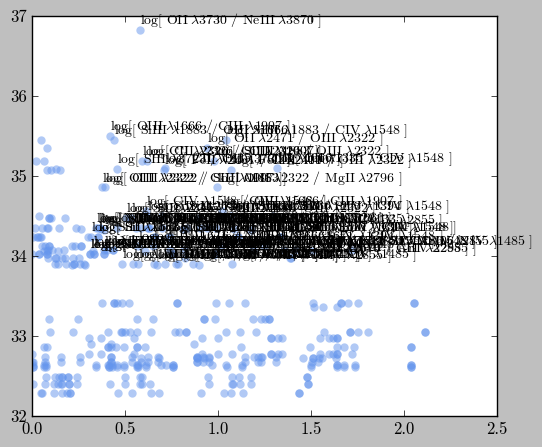

In [61]:
age = 4.0e6
logZ = -0.5
mod_inds = (zau.logZ == logZ) & (zau.age == age)

lines = np.array(rlines.keys())
wavs = np.array(rlines.values())
sinds = np.argsort(wavs)

fig, ax = plt.subplots(1, figsize=(6,5))
best_x = []
best_y = []
best_l = []
best_w = []
best_n = []
for i_ind, ii in enumerate(sinds):
    line = lines[ii]
    wav = wavs[ii]
    ratio_names = []
    ratio_meds = []
    ratio_stds = []
    ratio_labels = []
    ratio_dists = []
    ratio_diffs = []
    for i, si in enumerate(sinds):
        iline = lines[si]
        iwav = wavs[si]
        if (i_ind < i):
        #if (iline != line) & (wav < iwav):
            line_arr = zau.__getattribute__(line)[mod_inds]
            iline_arr = zau.__getattribute__(iline)[mod_inds]
            if np.max(line_arr) > np.max(iline_arr):
                # if line is more luminous, it goes on bottom
                top, twav = iline, iwav
                bot, bwav = line, wav
                top_arr = iline_arr
                bot_arr = line_arr
            else:
                top, twav = line, wav
                bot, bwav = iline, iwav
                top_arr = line_arr
                bot_arr = iline_arr
            ###
            wav_diff = np.abs(twav - bwav)
            if wav_diff <= 500.:
                ratio_name = '_'.join(['log', top, bot])
                #print ratio_name
                tt = top.split('_')[0]
                bb = bot.split('_')[0]
                ratio_label = r'log[ {0}$\;\lambda${1:.0f} / {2}$\;\lambda${3:.0f} ]'.format(tt, twav, bb, bwav)
                ratio_arr = np.log10(top_arr/bot_arr)
                #
                med = np.median(np.log10(top_arr)) ## using median lum
                std = np.std(ratio_arr)
                #
                ratio_names.append(ratio_name)
                ratio_labels.append(ratio_label)
                ratio_meds.append(med)
                ratio_stds.append(std)
                ratio_diffs.append(wav_diff)
    wav_diffs = np.array(ratio_diffs)
    xarr = np.array(ratio_stds)
    yarr = np.array(ratio_meds)
    labs = np.array(ratio_labels)
    ax.plot(xarr, yarr, 'o', color='CornflowerBlue', markeredgecolor='None', alpha=0.5)
    [ax.annotate(lab, xy=(x,y),
                 fontsize=10, xycoords='data',
                 ha='left', va='bottom')
     for lab,x,y in zip(labs, xarr, yarr) if (x > 0.3) & (y > 33.5)]
    [best_x.append(x) for x in xarr]
    [best_y.append(y) for y in yarr]
    [best_l.append(l) for l in labs]
    [best_w.append(w) for w in wav_diffs]
    [best_n.append(n) for n in ratio_names]
#fig.savefig('./figs/ratio_grids/{}.png'.format(line))
#plt.ylim(34,34.5)

419 25
[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5]


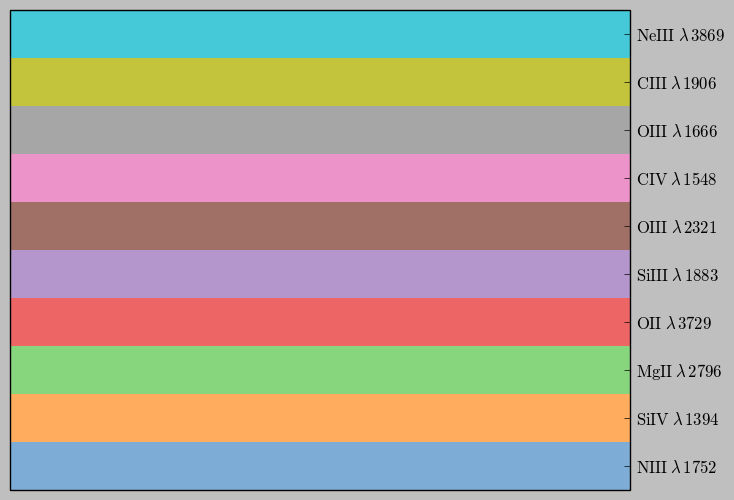

In [62]:
#
xarr, yarr = np.array(best_x), np.array(best_y)
larr, warr = np.array(best_l), np.array(best_w)
narr = np.array(best_n)
#

ylims = (34.4, 38.6)
xlims = (0.3, 1.4)
yinds = (yarr >= ylims[0]) & (yarr < ylims[1]) & (xarr >= xlims[0]) & (xarr <= xlims[1])
yis, = np.nonzero(yinds)
print len(xarr), len(yis)

# grabbing colorbar names
all_names = narr[yis]
all_ys = yarr[yis]
all_denom_names = np.array(['_'.join(all_names[i].split('_')[-2::]) for i in range(len(all_names))])
unsorted_denom_names = np.unique(all_denom_names)
# sorting on y-value
unsorted_denom_ys = np.zeros(len(unsorted_denom_names))
for i in range(len(all_names)):
    full_ratio_name = all_names[i]
    yval = all_ys[i]
    denom_name = all_denom_names[i]
    ii = np.where(unsorted_denom_names == denom_name)[0][0]
    if yval > unsorted_denom_ys[ii]:
        unsorted_denom_ys[ii] = yval
unsorted_denom_wls = np.array([float(unsorted_denom_names[i].split('_')[-1]) for i in range(len(unsorted_denom_names))])
#swli = np.argsort(unsorted_denom_wls) # sorting on y val now
swli = np.argsort(unsorted_denom_ys)
denom_names = unsorted_denom_names[swli]
snames = np.array([denom_names[i].replace('_',r'$\;\lambda\,$') for i in range(len(denom_names))])
nbounds = len(denom_names)+1
bounds = np.arange(0,nbounds,1)
# location of line labels
tick_locs = bounds[0:-1]+0.5
print tick_locs
#create colormap
#cols = nColors(nbounds, cname='Set2', minv=0.0, maxv=1.0)
sM = getColors(np.arange(0, nbounds, 1), cname='Vega20', minv=0.0, maxv=1.0)
cols = [sM.to_rgba(i) for i in tick_locs]

cmap = mpl.colors.ListedColormap(cols)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cdict = {}
for i in range(len(all_names)):
    full_ratio_name = all_names[i]
    denom_name = all_denom_names[i]
    ii = np.where(denom_names == denom_name)[0][0]
    cdict[full_ratio_name] = cols[ii]
    #print denom_name, denom_names[ii]


#plot
fig, ax = plt.subplots()

cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm,
                               ticks=tick_locs,
                               spacing='proportional',
                               orientation='vertical')
cb.set_ticklabels(snames)


419 25


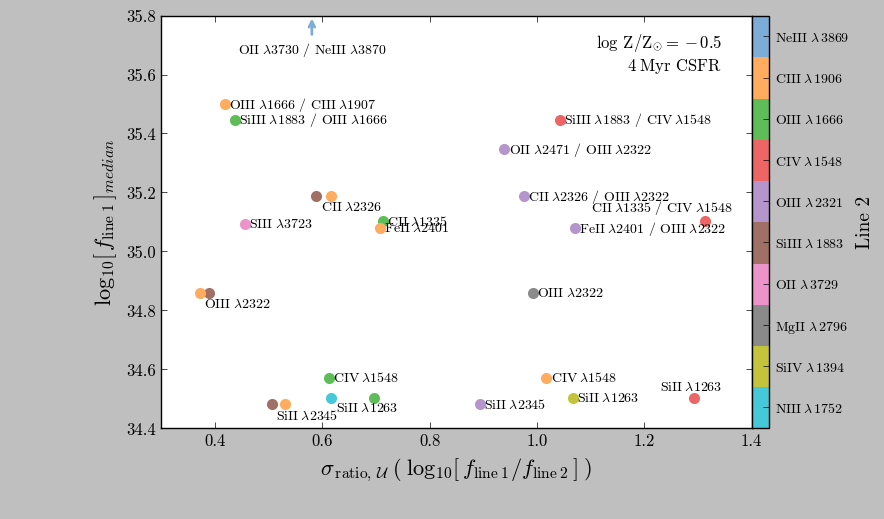

In [79]:
#
xarr, yarr = np.array(best_x), np.array(best_y)
larr, warr = np.array(best_l), np.array(best_w)
narr = np.array(best_n)
#

ylims = (34.4, 38.6)
xlims = (0.3, 1.4)
yinds = (yarr >= ylims[0]) & (yarr < ylims[1]) & (xarr >= xlims[0]) & (xarr <= xlims[1])
yis, = np.nonzero(yinds)
print len(xarr), len(yis)

# grabbing colorbar names
all_names = narr[yis]
all_ys = yarr[yis]
all_denom_names = np.array(['_'.join(all_names[i].split('_')[-2::]) for i in range(len(all_names))])
unsorted_denom_names = np.unique(all_denom_names)
# sorting on y-value
unsorted_denom_ys = np.zeros(len(unsorted_denom_names))
for i in range(len(all_names)):
    full_ratio_name = all_names[i]
    yval = all_ys[i]
    denom_name = all_denom_names[i]
    ii = np.where(unsorted_denom_names == denom_name)[0][0]
    if yval > unsorted_denom_ys[ii]:
        unsorted_denom_ys[ii] = yval
unsorted_denom_wls = np.array([float(unsorted_denom_names[i].split('_')[-1]) for i in range(len(unsorted_denom_names))])
#swli = np.argsort(unsorted_denom_wls) # sorting on y val now
swli = np.argsort(unsorted_denom_ys)
denom_names = unsorted_denom_names[swli]
snames = np.array([denom_names[i].replace('_',r'$\;\lambda\,$') for i in range(len(denom_names))])
nbounds = len(denom_names)+1
# location of line labels
tick_locs = bounds[0:-1]+0.5

#create colormap
sM = getColors(np.arange(0, nbounds, 1), cname='Vega20_r', minv=0.0, maxv=1.0)
cols = [sM.to_rgba(i) for i in tick_locs]
cmap = mpl.colors.ListedColormap(cols)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cdict = {}
for i in range(len(all_names)):
    full_ratio_name = all_names[i]
    denom_name = all_denom_names[i]
    ii = np.where(denom_names == denom_name)[0][0]
    cdict[full_ratio_name] = cols[ii]

fig, (ax, cax) = plt.subplots(1,2, figsize=(8,4.85), gridspec_kw={"width_ratios":[1, 0.03]})

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                               ticks=tick_locs,
                               spacing='proportional',
                               orientation='vertical')
cb.set_ticklabels(snames)
cb.ax.tick_params(labelsize=10)
cb.set_label('Line 2', size=14)


#fig, ax = plt.subplots(1, figsize=(5,4.5))
for yi in yis:
    x,y,l,n = xarr[yi], yarr[yi], larr[yi], narr[yi]
    
    color = cdict[n]
    la = l.strip('log[ ').split(' / ')[0]
    ax.plot(x, y, 'o', markersize=8,
            color=color, markeredgecolor='None', alpha=1.0)
    xo = 3
    yo = 0
    ha = 'left'
    va = 'center'
    fontsize=10
    if y > 36.5:
        ha='center'
        va='top'
        la = l.strip('log[ ').strip(' ]')
        ax.annotate(la, xy=(x,1.00),fontsize=fontsize,
                    xytext=(x, 0.94),
                    xycoords=('data','axes fraction'), ha=ha, va=va,
                    textcoords=('data','axes fraction'), arrowprops=dict(arrowstyle="->", color=color, lw=2))
    if y < 33.8:
        if (x < 0.5) & (x > 0.45):
            va='bottom'
            yo = np.random.randint(0, 10)
        elif x <= 0.45:
            va='top'
            yo = np.random.randint(-15, 0)
    if x > 1.2:
        ha = 'right'
        xo=20
        yo=3
        va='bottom'
    if la[-4::] == '1531':
        if x <0.35:
            la=''
    if la[-4::] == '1752':
        if (x > 0.35) & (x < 0.4):
            la=''
        elif x < 0.35:
            va='top'
            ha='left'
            xo=0
            yo=-3
    if (x < 0.4) & (y < 34.6):
        if la[-4::] == '2142':
            ha='left'
            xo=0
            va='bottom'
            yo=3
        elif la[-4::] == '1394':
            ha='left'
            xo=0
            va='top'
            yo=-3
    if la[-4::] == '2322':
        if (x < 0.4):
            if (x > 0.38):
                la=''
            else:
                va='top'
                yo=-3
    if la[-4::] == '2326':
        if (x < 0.7):
            if (x > 0.6):
                la=''
            else:
                va='top'
                yo=-3
    if la[-4::] == '2345':
        if (x < 0.6):
            if (x > 0.52):
                la=''
            else:
                va='top'
                yo=-3
    if la[-4::] == '1263':
        if (x < 0.75):
            if (x > 0.65):
                la=''
            else:
                va='top'
                yo=-3
    if (y >= 35.2):
        la = l.strip('log[ ').strip(' ]')
    if (y >= 35.0) & (x >= 0.9):
        la = l.strip('log[ ').strip(' ]')
    ax.annotate(la, xy=(x,y),fontsize=fontsize,
                xytext=(xo, yo),
                xycoords='data',ha=ha, va=va,
                textcoords='offset points')#,

ax.set_ylim(34.4, 35.8)
ax.set_xlim(xlims)
ax.set_xlabel(r'$\sigma_{\,\mathrm{ratio,\,}\mathcal{U}}\;(\;\log_{10} [\,f_{\mathrm{line\;1}}/f_{\mathrm{line\;2}}\,]\;)$', size=16)
ax.set_ylabel(r'$\log_{10} [\,f_{\mathrm{line\;1}}\,]_{median}$', size=16)
ax.annotate(r'log Z/Z$_{{\odot}}={0:.1f}$'.format(logZ),
            xy=(0.95,0.96), xycoords='axes fraction',
            size=12,ha='right', va='top')
ax.annotate(r'${0:.0f}\;$Myr CSFR'.format(age*1.e-6),
            xy=(0.95,0.9), xycoords='axes fraction',
            size=12,ha='right', va='top')

fig.subplots_adjust(wspace=0.0, top=0.98, bottom=0.13, left=0.10, right=0.86)
fig.savefig('../figs/f9.pdf')
fig.savefig('../figs/f9.png')

In [29]:
av_logz = -0.5
av_logu = -2.5
av_age = 4.e6
av_ind = int(np.nonzero((zau.logZ == av_logz) &
                        (zau.logU == av_logu) &
                        (zau.age == av_age))[0])

In [30]:
g_ratio_names =  ['log_OIII_1666_CIII_1906', 'log_OIII_2321_CII_2326', 'log_OII_3729_NeIII_3869', 'log_OIII_2322_MgII_2796', 'log_CII_2326_SiIII_1883', 'log_SiII_1263_CII_1335', 'log_NIII_1752_OIII_1666', 'log_SiIII_1883_CIII_1906']
g_ratio_labels =  ['log[ OIII$\\;\\lambda$1666 / CIII$\\;\\lambda$1907 ]', 'log[ OIII$\\;\\lambda$2322 / CII$\\;\\lambda$2326 ]', 'log[ OII$\\;\\lambda$3730 / NeIII$\\;\\lambda$3870 ]', 'log[ OIII$\\;\\lambda$2322 / MgII$\\;\\lambda$2796 ]', 'log[ CII$\\;\\lambda$2326 / SiIII$\\;\\lambda$1883 ]', 'log[ SiII$\\;\\lambda$1263 / CII$\\;\\lambda$1335 ]', 'log[ NIII$\\;\\lambda$1752 / OIII$\\;\\lambda$1666 ]', 'log[ SiIII$\\;\\lambda$1883 / CIII$\\;\\lambda$1906 ]']
g_ratio_lines =  [('OIII_1666', 'CIII_1906'), ('OIII_2321', 'CII_2326'), ('OII_3729', 'NeIII_3869'), ('OIII_2321', 'MgII_2796'), ('CII_2326', 'SiIII_1883'), ('SiII_1263', 'CII_1335'), ('NIII_1752', 'OIII_1666'), ('SiIII_1883', 'CIII_1906')]

# Fig.10: ratios vs. logZ

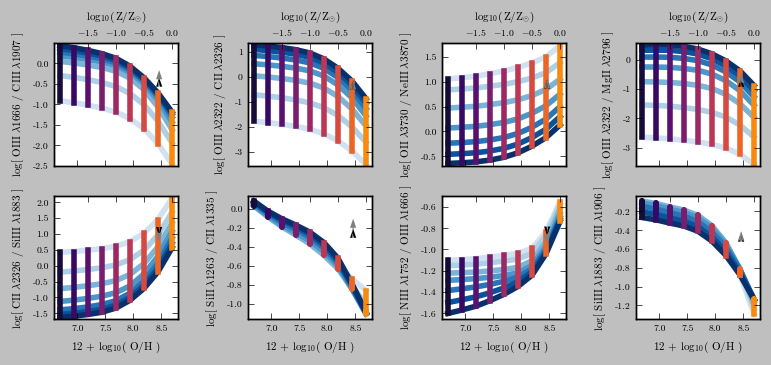

In [31]:
fig, ax = plt.subplots(2,4, figsize=(8.0,4.0), sharex='all')
age = 4.0e6
zmin, zmax = -2.0, 0.00

i=0
for ratio_name, ratio_line, ratio_label in zip(g_ratio_names, g_ratio_lines, g_ratio_labels):
    ax = fig.axes[i]
    a1, a2 = make_logZ_plot(zau, ratio_name, ratio_line, ratio_label,
                            ax=ax, zlims=(zmin, zmax), size=8, tsize=7,
                            width=0.01, head_width=0.05, av_ind=av_ind,
                            plot_reddening=True, Av=1, ann_av=False, ann_curve=False,figy=0.7, figx=0.85)
    if i <= 3:
        plt.setp(a1.xaxis.get_ticklabels(), visible=False)
        a1.set_xlabel('')
    else:
        plt.setp(a2.xaxis.get_ticklabels(), visible=False)
        a2.set_xlabel('')
    i+=1
fig.subplots_adjust(hspace=0.0, wspace=0.4)
fig.tight_layout()
fig.savefig('../figs/f10.pdf')
fig.savefig('../figs/f10.png')

# Fig.11: emission line strength vs. emission line variance

In [32]:
from sedpy import attenuation

### 11 (a)

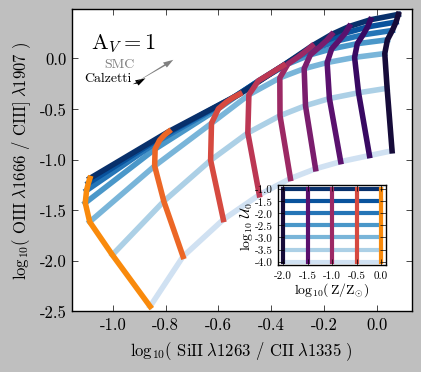

In [33]:
age = 4.0e6
zmin, zmax = -2.0, 0.0

xname =  'log_SiII_1263_CII_1335'
xlab = '$\\log_{10}$( SiII$\\;\\lambda$1263 / CII$\\;\\lambda$1335 )'
xratio = ('SiII_1263', 'CII_1335')
#
yname = 'log_OIII_1666_CIII_1907'
ylab = '$\\log_{10}$( OIII$\\;\\lambda$1666 / CIII]$\\;\\lambda$1907 )'
yratio = ('OIII_1666', 'CIII_1906')
#-------------------------------------------------------------------------------
yarr = np.log10(zau.__getattribute__(yratio[0])/zau.__getattribute__(yratio[1]))
zau.__setattr__(yname, yarr)
ywavs = np.array([ulined[yratio[0]], ulined[yratio[1]]])
inds = (zau.logZ >= zmin) & (zau.logZ <= zmax) & (zau.age == age)
arr = zau.__getattribute__(yname)[inds]
ylims = (arr.min()-0.05, arr.max()+0.05)
yflus = np.array([zau.__getattribute__(yratio[0])[av_ind],
                  zau.__getattribute__(yratio[1])[av_ind]])
######
xwavs = np.array([ulined[xratio[0]], ulined[xratio[1]]])
xarr = np.log10(zau.__getattribute__(xratio[0])/zau.__getattribute__(xratio[1]))
zau.__setattr__(xname, xarr)
arr = xarr[inds]
xlims = (arr.min()-0.05, arr.max()+0.05)
xflus = np.array([zau.__getattribute__(xratio[0])[av_ind],
                  zau.__getattribute__(xratio[1])[av_ind]])
######
fig, ax = plt.subplots(1, figsize=(4.5,4))
altBPT(zau, age=age, ax=ax, xname=xname, yname=yname,
       yclims=(zmin, zmax),xclims=(-4.0,-1.0),
       xlim=xlims, ylim=ylims)
######
Av = 1.0
figx, figy = 0.18, 0.75
plot_reddening_vector(xwavs, xflus, ywavs, yflus, ax=ax, Av=Av,
                      arrowcolor='black',
                      figx=figx, figy=figy,
                      xshift=-18, yshift=5,
                      dust_curve=attenuation.calzetti,
                      label='Calzetti')
plot_reddening_vector(xwavs, xflus, ywavs, yflus, ax=ax, Av=Av,
                      arrowcolor='grey',
                      figx=figx, figy=figy,
                      xshift=-10, yshift=15,
                      dust_curve=attenuation.smc,
                      label='SMC')
ax.annotate(r'A$_{{V}}={0:.0f}$'.format(Av),
            xy=(0.15, 0.85), fontsize=16,
            xycoords='axes fraction', ha='center', va='bottom')
ax.set_ylabel(ylab, size=12)
ax.set_xlabel(xlab, size=12)
plt.tight_layout()
make_inset(axlims=[.65, .3, .24, .20], lw=3, pad=0)
fig.savefig('../figs/f11a.pdf')
fig.savefig('../figs/f11a.png')

### 11 (b)

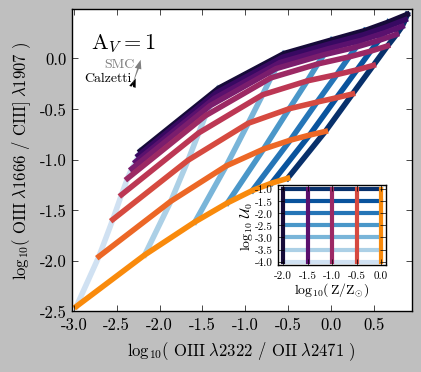

In [34]:
age = 4.0e6
zmin, zmax = -2.0, 0.0

xname =  'log_OIII_2321_OII_2471'
xlab = '$\\log_{10}$( OIII$\\;\\lambda$2322 / OII$\\;\\lambda$2471 )'
xratio = ('OIII_2321', 'OII_2471')
#
yname = 'log_OIII_1666_CIII_1907'
ylab = '$\\log_{10}$( OIII$\\;\\lambda$1666 / CIII]$\\;\\lambda$1907 )'
yratio = ('OIII_1666', 'CIII_1906')
#-------------------------------------------------------------------------------
yarr = np.log10(zau.__getattribute__(yratio[0])/zau.__getattribute__(yratio[1]))
zau.__setattr__(yname, yarr)
ywavs = np.array([ulined[yratio[0]], ulined[yratio[1]]])
inds = (zau.logZ >= zmin) & (zau.logZ <= zmax) & (zau.age == age)
arr = zau.__getattribute__(yname)[inds]
ylims = (arr.min()-0.05, arr.max()+0.05)
yflus = np.array([zau.__getattribute__(yratio[0])[av_ind],
                  zau.__getattribute__(yratio[1])[av_ind]])
######
xwavs = np.array([ulined[xratio[0]], ulined[xratio[1]]])
xarr = np.log10(zau.__getattribute__(xratio[0])/zau.__getattribute__(xratio[1]))
zau.__setattr__(xname, xarr)
arr = xarr[inds]
xlims = (arr.min()-0.05, arr.max()+0.05)
xflus = np.array([zau.__getattribute__(xratio[0])[av_ind],
                  zau.__getattribute__(xratio[1])[av_ind]])
######
fig, ax = plt.subplots(1, figsize=(4.5,4))
altBPT(zau, age=age, ax=ax, xname=xname, yname=yname,
       yclims=(zmin, zmax),xclims=(-4.0,-1.0),
       xlim=xlims, ylim=ylims)
######
Av = 1.0
figx, figy = 0.18, 0.75
plot_reddening_vector(xwavs, xflus, ywavs, yflus, ax=ax, Av=Av,
                      arrowcolor='black',
                      figx=figx, figy=figy,
                      xshift=-18, yshift=5,
                      dust_curve=attenuation.calzetti,
                      label='Calzetti')
plot_reddening_vector(xwavs, xflus, ywavs, yflus, ax=ax, Av=Av,
                      arrowcolor='grey',
                      figx=figx, figy=figy,
                      xshift=-10, yshift=15,
                      dust_curve=attenuation.smc,
                      label='SMC')
ax.annotate(r'A$_{{V}}={0:.0f}$'.format(Av),
            xy=(0.15, 0.85), fontsize=16,
            xycoords='axes fraction', ha='center', va='bottom')
ax.set_ylabel(ylab, size=12)
ax.set_xlabel(xlab, size=12)
plt.tight_layout()
make_inset(axlims=[.65, .3, .24, .20], lw=3, pad=0)
fig.savefig('../figs/f11b.pdf')
fig.savefig('../figs/f11b.png')


### 11 (c)

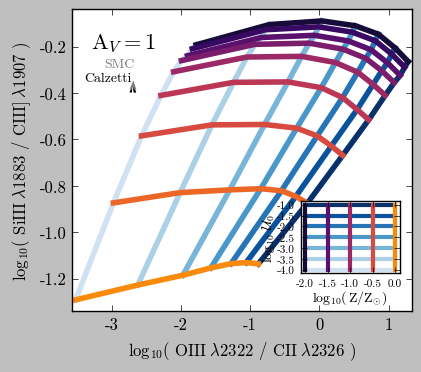

In [35]:
age = 4.0e6
zmin, zmax = -2.0, 0.0

xname =  'log_OIII_2321_CII_2326'
xlab = '$\\log_{10}$( OIII$\\;\\lambda$2322 / CII$\\;\\lambda$2326 )'
xratio = ('OIII_2321', 'CII_2326')
#
yname = 'log_SiIII_1883_CIII_1907'
ylab = '$\\log_{10}$( SiIII$\\;\\lambda$1883 / CIII]$\\;\\lambda$1907 )'
yratio = ('SiIII_1883', 'CIII_1906')
#-------------------------------------------------------------------------------
yarr = np.log10(zau.__getattribute__(yratio[0])/zau.__getattribute__(yratio[1]))
zau.__setattr__(yname, yarr)
ywavs = np.array([ulined[yratio[0]], ulined[yratio[1]]])
inds = (zau.logZ >= zmin) & (zau.logZ <= zmax) & (zau.age == age)
arr = zau.__getattribute__(yname)[inds]
ylims = (arr.min()-0.05, arr.max()+0.05)
yflus = np.array([zau.__getattribute__(yratio[0])[av_ind],
                  zau.__getattribute__(yratio[1])[av_ind]])
######
xwavs = np.array([ulined[xratio[0]], ulined[xratio[1]]])
xarr = np.log10(zau.__getattribute__(xratio[0])/zau.__getattribute__(xratio[1]))
zau.__setattr__(xname, xarr)
arr = xarr[inds]
xlims = (arr.min()-0.05, arr.max()+0.05)
xflus = np.array([zau.__getattribute__(xratio[0])[av_ind],
                  zau.__getattribute__(xratio[1])[av_ind]])
######
fig, ax = plt.subplots(1, figsize=(4.5,4))
altBPT(zau, age=age, ax=ax, xname=xname, yname=yname,
       yclims=(zmin, zmax),xclims=(-4.0,-1.0),
       xlim=xlims, ylim=ylims)
######
Av = 1.0

figx, figy = 0.18, 0.75
plot_reddening_vector(xwavs, xflus, ywavs, yflus, ax=ax, Av=Av,
                      arrowcolor='black',
                      figx=figx, figy=figy,
                      xshift=-18, yshift=5,
                      dust_curve=attenuation.calzetti,
                      label='Calzetti')
plot_reddening_vector(xwavs, xflus, ywavs, yflus, ax=ax, Av=Av,
                      arrowcolor='grey',
                      figx=figx, figy=figy,
                      xshift=-10, yshift=15,
                      dust_curve=attenuation.smc,
                      label='SMC')
ax.annotate(r'A$_{{V}}={0:.0f}$'.format(Av),
            xy=(0.15, 0.85), fontsize=16,
            xycoords='axes fraction', ha='center', va='bottom')
ax.set_ylabel(ylab, size=12)
ax.set_xlabel(xlab, size=12)
plt.tight_layout()
make_inset(axlims=[.70, .28, .22, .18], lw=3, pad=0)
fig.savefig('../figs/f11c.pdf')
fig.savefig('../figs/f11c.png')

In [36]:
def grab_absLines2(logZ=0.0, age=1.0, logU=-2.0, return_time=False, line_index=5,
                  isochrone='mist', sfh='burst', lineset='L', logt=False, tempFix=False):
    '''
    returns the 11 Leitherer absorption line indices for the specified parameters
    '''
    #logZs = [-1.0, -0.5, 0.0, 0.5]
    #if logZ not in logZs:
    #    return np.full(11, np.nan)
    Zstr = 'm{0:02.0f}'.format(np.abs(logZ)*10) if logZ < 0.0 else 'p{0:02.0f}'.format(np.abs(logZ)*10)
    Ustr = 'logU_{0:.1f}_'.format(logU*-1)
    dir_='/astro/users/ebyler/research/uvem/data'
    subdir='AbsEmData'
    #subdir='EW'
    estr='e_'
    fname = dir_+'/{}/{}{}_{}_{}_EW_{}.dat'.format(subdir, Ustr,
                                                   isochrone,
                                                   sfh,
                                                   lineset,
                                                   Zstr)
    try:
        data = np.genfromtxt(fname, delimiter=',', unpack=True, dtype=None)
    except:
        print '{} does not exist'.format(fname.split('/')[-1])
        return np.full(11, np.nan)
    
    data = np.genfromtxt(fname, delimiter=',', unpack=True, dtype=None)
    ages = data[0]
    if tempFix:
        ages = np.arange(5., 7.10, 0.05)
    agesMyr = (10.**ages)/1.e6
    if return_time:
        if logt:
            outage = ages
        else:
            outage = agesMyr
        return (outage, data[1::][line_index])
    else:
        age_ind = np.argmin(np.abs(agesMyr - age))
        return data[1::, age_ind]

In [37]:
zau.EWs = np.full((zau.nmods, 11), 0.0)
for logZ in zau.logZ_vals:
    for age in zau.age_vals:
        for logU in zau.logU_vals:
            modind, = np.where((zau.logZ == logZ) & (zau.age == age) & (zau.logU == logU))
            ind = int(modind)
            zau.EWs[ind] = grab_absLines2(logZ=logZ, age=age/1.e6, logU=logU,
                                          tempFix=False, sfh='csfr')
# create a few absorption line attributes for testing
zau.abs_CIV = zau.EWs[:,4]
zau.abs_MgII = zau.EWs[:,10]
zau.abs_AlII = zau.EWs[:,6]
zau.abs_AlIII = zau.EWs[:,7]
zau.abs_FeII = zau.EWs[:,5]

#
flname = '/astro/users/ebyler/research/uvem/data/UVabs.dat'
data = np.genfromtxt(flname, skip_header=1, names=True, dtype=None, delimiter=',', unpack=True)
index = [dat['Index'] for dat in data]
bandpass = [[float(a) for a in dat['Bandpass'].split('-')] for dat in data]
rcont = [[float(a) for a in dat['RedCont'].split('-')] for dat in data]
bcont = [[float(a) for a in dat['BlueCont'].split('-')] for dat in data]
nindex = len(index)

logU_4.0_mist_csfr_L_EW_m25.dat does not exist
logU_3.5_mist_csfr_L_EW_m25.dat does not exist
logU_3.0_mist_csfr_L_EW_m25.dat does not exist
logU_2.5_mist_csfr_L_EW_m25.dat does not exist
logU_2.0_mist_csfr_L_EW_m25.dat does not exist
logU_1.5_mist_csfr_L_EW_m25.dat does not exist
logU_1.0_mist_csfr_L_EW_m25.dat does not exist
logU_4.0_mist_csfr_L_EW_m25.dat does not exist
logU_3.5_mist_csfr_L_EW_m25.dat does not exist
logU_3.0_mist_csfr_L_EW_m25.dat does not exist
logU_2.5_mist_csfr_L_EW_m25.dat does not exist
logU_2.0_mist_csfr_L_EW_m25.dat does not exist
logU_1.5_mist_csfr_L_EW_m25.dat does not exist
logU_1.0_mist_csfr_L_EW_m25.dat does not exist
logU_4.0_mist_csfr_L_EW_m25.dat does not exist
logU_3.5_mist_csfr_L_EW_m25.dat does not exist
logU_3.0_mist_csfr_L_EW_m25.dat does not exist
logU_2.5_mist_csfr_L_EW_m25.dat does not exist
logU_2.0_mist_csfr_L_EW_m25.dat does not exist
logU_1.5_mist_csfr_L_EW_m25.dat does not exist
logU_1.0_mist_csfr_L_EW_m25.dat does not exist
logU_4.0_mist

# Fig.12: absorption + emission diagnostic diagrams

/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


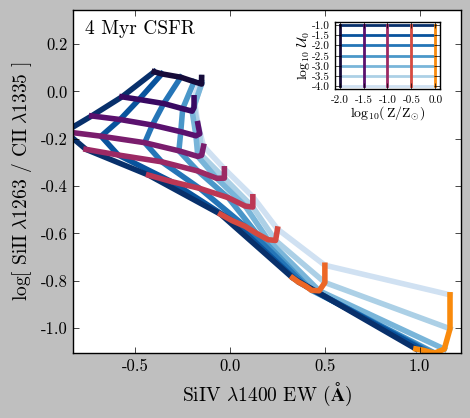

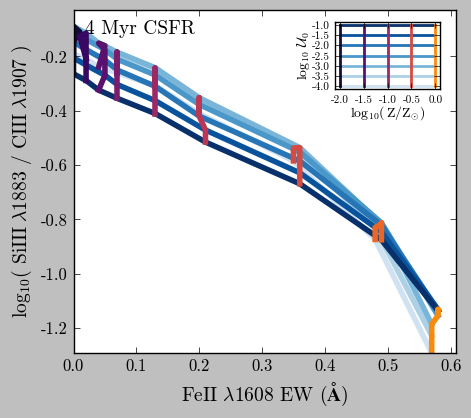

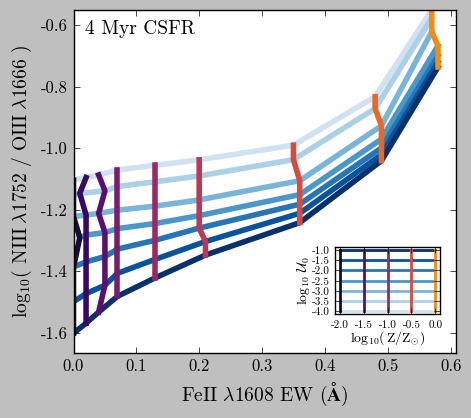

In [38]:
age = 4.0e6
yclims=(-2.5, 0.0)
xclims=(-4.0,-1.0)

yname = 'log_SiII_1263_CII_1335'
ylab = 'log[ SiII$\\;\\lambda$1263 / CII$\\;\\lambda$1335 ]'
yratio = ('SiII_1263', 'CII_1335')
#-----------
yarr = np.log10(zau.__getattribute__(yratio[0])/zau.__getattribute__(yratio[1]))
zau.__setattr__(yname, yarr)
mds = (zau.age == age) & (zau.logZ >= yclims[0]) & (zau.logZ <= yclims[1])
yyarr = zau.__getattribute__(yname)[mds]
###
fig, ax = plt.subplots(1, figsize=(5,4.5))
i=2
zau.abs_i = zau.EWs[:,i]
xlab, xname = index[i+1].replace('_', r' $\lambda$')+r' EW ($\mathrm{\AA}$)', 'abs_i'
mds = (zau.age == age) & (zau.logZ >= yclims[0]) & (zau.logZ <= yclims[1])
arr = zau.abs_i[mds]
altBPT(zau, age=age, ax=ax, xname=xname, yname=yname,
        yclims=yclims,xclims=xclims,
        xlim=(np.nanmin(arr)*0.95, np.nanmax(arr)*1.05),
        ylim=(np.nanmin(yyarr), np.nanmax(yyarr)))
make_inset(axlims=[.7, .77, .21, .15], pad=0)
ax.annotate('4 Myr CSFR', xy=(0.03,0.97),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='top')
ax.set_xlabel(xlab, size=14)
    #plt.setp(ax.get_xticklabels(), size=10)
ax.set_ylabel(ylab, size=14)
plt.tight_layout()
plt.savefig('../figs/f12a.pdf')
plt.savefig('../figs/f12a.png')
#-----------
yname = 'log_SiIII_1883_CIII_1906'
ylab = '$\\log_{10}$( SiIII$\\;\\lambda$1883 / CIII$\\;\\lambda$1907 )'
yratio = ('SiIII_1883', 'CIII_1906')
#-----------
yarr = np.log10(zau.__getattribute__(yratio[0])/zau.__getattribute__(yratio[1]))
zau.__setattr__(yname, yarr)
mds = (zau.age == age) & (zau.logZ >= yclims[0]) & (zau.logZ <= yclims[1])
yyarr = zau.__getattribute__(yname)[mds]
###
fig, ax = plt.subplots(1, figsize=(5,4.5))
i=5
zau.abs_i = zau.EWs[:,i]
xlab, xname = index[i+1].replace('_', r' $\lambda$')+r' EW ($\mathrm{\AA}$)', 'abs_i'
mds = (zau.age == age) & (zau.logZ >= yclims[0]) & (zau.logZ <= yclims[1])
arr = zau.abs_i[mds]
altBPT(zau, age=age, ax=ax, xname=xname, yname=yname,
        yclims=yclims,xclims=xclims,
        xlim=(np.nanmin(arr)*0.95, np.nanmax(arr)*1.05),
        ylim=(np.nanmin(yyarr), np.nanmax(yyarr)))
make_inset(axlims=[.7, .77, .21, .15], pad=0)
ax.annotate('4 Myr CSFR', xy=(0.03,0.97),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='top')
ax.set_xlabel(xlab, size=14)
    #plt.setp(ax.get_xticklabels(), size=10)
ax.set_ylabel(ylab, size=14)
plt.tight_layout()
plt.savefig('../figs/f12b.pdf')
plt.savefig('../figs/f12b.png')
#-----------
yname =  'log_NIII_1752_OIII_1666'
ylab = '$\\log_{10}$( NIII$\\;\\lambda$1752 / OIII$\\;\\lambda$1666 )'
yratio = ('NIII_1752', 'OIII_1666')
#-----------
yarr = np.log10(zau.__getattribute__(yratio[0])/zau.__getattribute__(yratio[1]))
zau.__setattr__(yname, yarr)
mds = (zau.age == age) & (zau.logZ >= yclims[0]) & (zau.logZ <= yclims[1])
yyarr = zau.__getattribute__(yname)[mds]
###
fig, ax = plt.subplots(1, figsize=(5,4.5))
i=5
zau.abs_i = zau.EWs[:,i]
xlab, xname = index[i+1].replace('_', r' $\lambda$')+r' EW ($\mathrm{\AA}$)', 'abs_i'
mds = (zau.age == age) & (zau.logZ >= yclims[0]) & (zau.logZ <= yclims[1])
arr = zau.abs_i[mds]
altBPT(zau, age=age, ax=ax, xname=xname, yname=yname,
        yclims=yclims,xclims=xclims,
        xlim=(np.nanmin(arr)*0.95, np.nanmax(arr)*1.05),
        ylim=(np.nanmin(yyarr), np.nanmax(yyarr)))
make_inset(axlims=[.7, .27, .21, .15], pad=0)
ax.annotate('4 Myr CSFR', xy=(0.03,0.97),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='top')
ax.set_xlabel(xlab, size=14)
    #plt.setp(ax.get_xticklabels(), size=10)
ax.set_ylabel(ylab, size=14)
plt.tight_layout()
plt.savefig('../figs/f12c.pdf')
plt.savefig('../figs/f12c.png')
#-----------

In [39]:
sfh='burst'
if sfh=='burst':
    fname = '/astro/users/ebyler/research/uvem/data/ZAU_ext_b_lum.lines'
else:
    fname = '/astro/users/ebyler/research/uvem/data/ZAU_CSFR_ext_b_lum.lines'
zau = modObj(fname)

uvdat = np.genfromtxt('/astro/users/ebyler/python/mangst/mangst/emLines_UV.dat', delimiter='\t', dtype=None)
ulines = []
ulined = {}

#uvdat = np.genfromtxt('./local_emLines.dat', delimiter='\t', dtype=None)
#ulines = []
#ulined = {}
i=0
for u in uvdat:
        oname = u[0].replace('[', '').replace(']', '').replace('-', '').replace('$', '').replace('\\','_')
        if oname[0:2] not in ['HI', 'Br', 'Ly', 'Pa', 'Ba', 'PI', 'P5', 'P6', 'P7', 'P8', 'H5','H6','H7','H8', 'Pf', 'Hu', 'H_']:
            float_lambda = float(u[1])
            if (float_lambda < 3900.0) & (float_lambda > 1220.):
                i += 1
                wl = int(u[1])
                lam = u[1]
                dname = '{}_{}'.format(oname, wl)
                if dname in ulined.keys():
                    suff = '{0:.2f}'.format(lam)
                    dname = '{}_{}'.format(oname, suff.replace('.', '_'))
                ulines.append((dname, lam))
                ulined[dname] = lam
zau.add_lines(ulined)

zau.nlR23 = 10.**zau.R23
zau.O32 = 10.**zau.log_OIII_OII
zau.gas_logZ = zau.logZ + 12. + -3.31

ulined['OIII_5007']=5006.8
ulined['Hb']=4861.0
ulined['hb']=4861.0
ulined['Ha']=6562.0
ulined['ha']=6562.0
ulined['OIII_2'] = np.mean([5007.,4959.])
ulined['OII_2'] = np.mean([3727., 3729.])
ulined['NII_2'] = 6584.
zau.OIII_5007 = zau.OIIIb
zau.OIII_2 = zau.OIIIa + zau.OIIIb
zau.OII_2 = zau.OII_3727 + zau.OII_3729
zau.NII_2 = zau.NIIb
#bst.OIII_5007 = bst.OIIIb
zau.hb = zau.Hb

# Fig. 13: UV vs. Optical ratios

/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


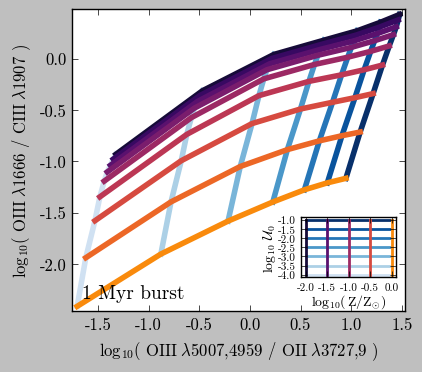

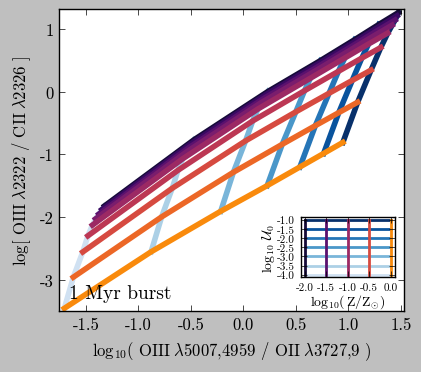

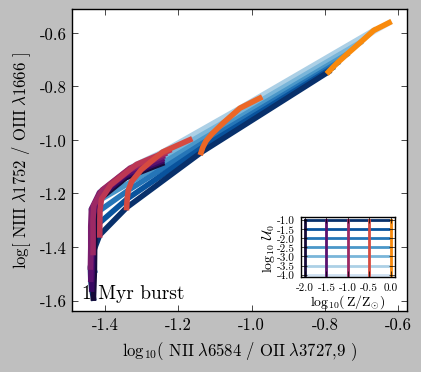

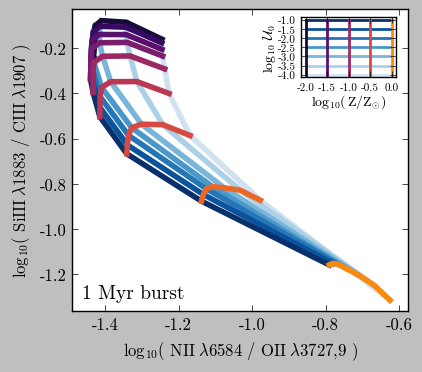

In [40]:
#--------------------------------------------------
# 12 (a)
#--------------------------------------------------
xname, xlab, xratio = 'log_OIII_OII_2', '$\\log_{10}$( OIII$\\;\\lambda$5007,4959 / OII$\\;\\lambda$3727,9 )', ('OIII_2', 'OII_2')
yname, ylab, yratio = 'log_OIII_1666_CIII_1906', '$\\log_{10}$( OIII$\\;\\lambda$1666 / CIII$\\;\\lambda$1907 )', ('OIII_1666', 'CIII_1906')
fig, ax = plt.subplots(1, figsize=(4.5,4))
ratio_ratio(zau, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.7, age=1.e6, av_ind=av_ind, plot_Av=False)
make_inset(axlims=[.7, .27, .21, .15], pad=0)
ax.annotate('1 Myr burst', xy=(0.03,0.03),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='bottom')
fig.tight_layout()
fig.savefig('../figs/f13a.pdf'.format(xname, yname))
fig.savefig('../figs/f13a.png'.format(xname, yname))

#--------------------------------------------------
# 12 (b)
#--------------------------------------------------
yname, ylab, yratio = 'log_OIII_2321_CII_2326', 'log[ OIII$\\;\\lambda$2322 / CII$\\;\\lambda$2326 ]',('OIII_2321', 'CII_2326')
xname, xlab, xratio = 'log_OIII_OII_2', '$\\log_{10}$( OIII$\\;\\lambda$5007,4959 / OII$\\;\\lambda$3727,9 )', ('OIII_2', 'OII_2')
fig, ax = plt.subplots(1, figsize=(4.5,4))
ratio_ratio(zau, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.7, age=1.e6, av_ind=av_ind, plot_Av=False)
make_inset(axlims=[.7, .27, .21, .15], pad=0)
ax.annotate('1 Myr burst', xy=(0.03,0.03),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='bottom')
ax.legend(loc=2, fontsize=10, numpoints=1,frameon=False)

fig.tight_layout()
fig.savefig('../figs/f13b.pdf')
fig.savefig('../figs/f13b.png')
#--------------------------------------------------
# 12 (c)
#--------------------------------------------------
xname, xlab, xratio = 'log_NII_OII', '$\\log_{10}$( NII$\\;\\lambda$6584 / OII$\\;\\lambda$3727,9 )', ('NII_2', 'OII_2')
yname, ylab, yratio = 'log_NIII_1752_OIII_1666','log[ NIII$\\;\\lambda$1752 / OIII$\\;\\lambda$1666 ]',('NIII_1752','OIII_1666')
fig, ax = plt.subplots(1, figsize=(4.5,4))
ratio_ratio(zau, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.7, age=1.e6, av_ind=av_ind, plot_Av=False)
make_inset(axlims=[.7, .27, .21, .15], pad=0)
ax.annotate('1 Myr burst', xy=(0.03,0.03),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='bottom')
fig.tight_layout()
fig.savefig('../figs/f13c.pdf')
fig.savefig('../figs/f13c.png')

#--------------------------------------------------
# 12 (d)
#--------------------------------------------------
xname, xlab, xratio = 'log_NII_OII', '$\\log_{10}$( NII$\\;\\lambda$6584 / OII$\\;\\lambda$3727,9 )', ('NII_2', 'OII_2')
yname, ylab, yratio = 'log_SiIII_1883_CIII_1906', '$\\log_{10}$( SiIII$\\;\\lambda$1883 / CIII$\\;\\lambda$1907 )', ('SiIII_1883', 'CIII_1906')

fig, ax = plt.subplots(1, figsize=(4.5,4))
ratio_ratio(zau, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.7, age=1.e6, av_ind=av_ind, plot_Av=False)
make_inset(axlims=[.7, .77, .21, .15], pad=0)
ax.annotate('1 Myr burst', xy=(0.03,0.03),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='bottom')
fig.tight_layout()
fig.savefig('../figs/f13d.pdf')
fig.savefig('../figs/f13d.png')